<a href="https://colab.research.google.com/github/silverstar0727/Kaggle_Santander-Product-Recommendation/blob/master/version_management/Agu5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 목표
고객이 신규로 구매할 제품이 무엇인가?

-> 고객이 2016-05-28 시점에 보유하고 있지 않은 금융 제품 중에서 2016-06-28에 구매할 것으로 예측되는 제품 상위 7개를 제출해야 한다.

## 평가척도 (MAP@7)
MAP은 Mean Average Precision이다. 먼저 Average Precision은 예측 정확도의 평균을 의미한다.
> 예를 들어 7개의 칼럼에 대한 예측을 정답은 1, 오답은 0이라고 할 때, 칼럼에 대한 예측결과가 1001110이라면, Average Precision은 1/1, 0, 0, 2/4, 4/6, 0이다.

Mean Average Precision은 모든 예측 결과물의 Average Precision의 평균값을 의미하고 @7이 붙는 이유는 최대 7개의 칼럼을 예측할 수 있다는 것을 의미한다.
> 위 예제에서는 (1/1 + 2/4 + 3/5 + 4/6) / 4 = 0.69 였다.

이러한 MAP@7 평가척도의 과정을 보면 예측의 순서에 매우 예민하다는 것을 알 수 있다.
> 7개의 예측 결과물 중 4개의 정답이 모두 처음에 위치하여 1111000과 같다면 Mean Average Precision은 (1/1 + 2/2 + 3/3 + 4/4) / 4 = 1이므로 최고 점수인 1이 될 것이다. 반대로 0001111이라면 Mean Average Precision은 0.43이 된다.

경진대회에서 MAP@7 평가 척도를 구하기 위해서는 다음의 코드를 사용한다. mapk()의 입력 값으로 들어가는 actual, predicted는 고객의 수 * 7의 dimension을 갖는 list of list이다.

In [ ]:
import numpy as np

def apk(acual, predicted, k = 7, default = 0.0):
  # MAP@7 이므로 최대 7개만 사용한다.
  if len(predicted) > k:
    predicted = predicted[:k]

  score = 0.0
  num_hits = 0.0

  for i, p in enumerate(predicted):
    # 점수를 부여하는 조건은 다음과 같다.
    # 예측 값이 정답에 있고 ('p in actual')
    # 예측값이 중복이 아니면 ('p not in predicted[:i]')
    if (p in actual) & (p not in predicted[:i]):
      num_hits += 1.0
      score += num_hits / (i + 1.0)

  # 정답값이 공백일 경우, 무조건 0.0점을 반환함
  if not actual:
    return default

  # 정답의 개수(len(actual))로 average precision을 구한다
  return score / min(len(actual), k)

def mapk(acual, predicted, k = 7, default = 0.0):
  # list of list인 정답 값(actual)과 예측값(predicted)에서 고객별 Average Precision을 구하고 np.mean()을 통해
  # 평균을 계산함
  return np.mean([apk(a, p, k, default) for a, p, in zip(actual, predicted)])

이번 경진대회에서는 Tabular형태의 시계열 데이터를 다루는데, 이 경우에는 딥러닝 모델보다 트리 기반의 앙상블 모델이 더 좋은 성능을 지닌다.

여기서는 주로 XGBoost와 LightGBM을 사용한다.

XGBoost 홈페이지: http://xgboost/readthedocs.io/en/latest

LightGBM: https://papers/nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-tree

In [ ]:
import pandas as pd
import numpy as np

train = pd.read_csv('/content/drive/My Drive/santander-product-recommendation/train_ver2.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,8,11,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# shape함수를 통한 훈련데이터의 크기 확인
train.shape

(13647309, 48)

In [ ]:
# 첫 다섯줄을 통해 데이터를 직접확인
train.head()

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,NaN,1,A,S,N,NaN,KHL,N,1.0,29.0,MALAGA,1.0,87218.10,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1,I,S,N,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,122179.11,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,NaN,1,I,S,N,NaN,KHD,N,1.0,50.0,ZARAGOZA,0.0,119775.54,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1,A,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0


다양한 유형의 변수가 존재하는 것을 확인할 수 있음

for문을 통해서 모든 변수의 첫 5줄을 미리보기

In [ ]:
for col in train.columns:
  print('{} \n'.format(train[col].head()))

# 각 column별 데이터 타입도 확인할 수 있음

0    2015-01-28
1    2015-01-28
2    2015-01-28
3    2015-01-28
4    2015-01-28
Name: fecha_dato, dtype: object 

0    1375586
1    1050611
2    1050612
3    1050613
4    1050614
Name: ncodpers, dtype: int64 

0    N
1    N
2    N
3    N
4    N
Name: ind_empleado, dtype: object 

0    ES
1    ES
2    ES
3    ES
4    ES
Name: pais_residencia, dtype: object 

0    H
1    V
2    V
3    H
4    V
Name: sexo, dtype: object 

0     35
1     23
2     23
3     22
4     23
Name: age, dtype: object 

0    2015-01-12
1    2012-08-10
2    2012-08-10
3    2012-08-10
4    2012-08-10
Name: fecha_alta, dtype: object 

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: ind_nuevo, dtype: float64 

0          6
1         35
2         35
3         35
4         35
Name: antiguedad, dtype: object 

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: indrel, dtype: float64 

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: ult_fec_cli_1t, dtype: object 

0    1
1    1
2    1
3    1
4    1
Name: indrel_1mes, 

## 탐색적 데이터 분석을 이용하여 우리가 얻고자 하는 것
* 전반적인 데이터 내용 파악
* 전처리를 해야하는 부분에 대한 파악
* 변수들 파악

In [ ]:
# 자동적 정보처리 함수
train.info()

# train의 데이터 타입이 모두 int나 float이 되도록 전처리를 해야한다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13647309 entries, 0 to 13647308
Data columns (total 48 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   fecha_dato             object 
 1   ncodpers               int64  
 2   ind_empleado           object 
 3   pais_residencia        object 
 4   sexo                   object 
 5   age                    object 
 6   fecha_alta             object 
 7   ind_nuevo              float64
 8   antiguedad             object 
 9   indrel                 float64
 10  ult_fec_cli_1t         object 
 11  indrel_1mes            object 
 12  tiprel_1mes            object 
 13  indresi                object 
 14  indext                 object 
 15  conyuemp               object 
 16  canal_entrada          object 
 17  indfall                object 
 18  tipodom                float64
 19  cod_prov               float64
 20  nomprov                object 
 21  ind_actividad_cliente  float64
 22  renta           

In [ ]:
# int64와 float64의 데이터 타입을 가지는 변수에 대해서 알아보기
num_cols = [col for col in train.columns[:24] if train[col].dtype in ['int64',  'float64']]
train[num_cols].describe()

# 다음의 변수들이 수치형 변수에 해당한다
# 'ncodpers', ind_nuevvo', indrel', tipodom', 'cos_prow', 'ind_actividad_cliente', 'renta'

,ncodpers,ind_nuevo,indrel,tipodom,cod_prov,ind_actividad_cliente,renta
count,1.364731e+07,1.361958e+07,1.361958e+07,13619574.0,1.355372e+07,1.361958e+07,1.085293e+07
mean,8.349042e+05,5.956184e-02,1.178399e+00,1.0,2.657147e+01,4.578105e-01,1.342543e+05
std,4.315650e+05,2.366733e-01,4.177469e+00,0.0,1.278402e+01,4.982169e-01,2.306202e+05
min,1.588900e+04,0.000000e+00,1.000000e+00,1.0,1.000000e+00,0.000000e+00,1.202730e+03
25%,4.528130e+05,0.000000e+00,1.000000e+00,1.0,1.500000e+01,0.000000e+00,6.871098e+04
50%,9.318930e+05,0.000000e+00,1.000000e+00,1.0,2.800000e+01,0.000000e+00,1.018500e+05
75%,1.199286e+06,0.000000e+00,1.000000e+00,1.0,3.500000e+01,1.000000e+00,1.559560e+05
max,1.553689e+06,1.000000e+00,9.900000e+01,1.0,5.200000e+01,1.000000e+00,2.889440e+07


In [ ]:
# object 데이터 타입을 갖는 변수에 대해서 알아보기
cat_cols = [col for col in train.columns[:24] if train[col].dtype in ['O']]
train[cat_cols].describe()

# 여기서 주의해야 할 것은 antiguedad는 수치형으로 분류되어야 한다.
# 누적 거래 기간을 나타내기 때문에 수치에 해당한다.

,fecha_dato,ind_empleado,pais_residencia,sexo,age,fecha_alta,antiguedad,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,nomprov,segmento
count,13647309,13619575,13619575,13619505,13647309,13619575,13647309,24793,13497528.0,13497528,13619575,13619575,1808,13461183,13619575,13553718,13457941
unique,17,5,118,2,235,6756,507,223,13.0,5,2,2,2,162,2,52,3
top,2016-05-28,N,ES,V,23,2014-07-28,0,2015-12-24,1.0,I,S,N,N,KHE,N,MADRID,02 - PARTICULARES
freq,931453,13610977,13553710,7424252,542682,57389,134335,763,7277607.0,7304875,13553711,12974839,1791,4055270,13584813,4409600,7960220


In [ ]:
# 범주형 변수의 고유값을 직접 출력해보기
for col in cat_cols:
  uniq = np.unique(train[col].astype(str))
  print('-' * 50)
  print('# col {}, n_uniq {}, uniqu {}'.format(col, len(uniq), uniq))

# 변수에 대한 특징
# fecha_data: 년 월 일 형태의 날짜데이터, 2015-01-28 ~ 2016-05-28이고 매달 28일에 나온 월별 데이터임
# ind_empleado: 고용지표이고 nan을 포함하고 있음
# pairs_residencia: 고객의 거주국가를 나타내고 대문자 알파벳 두글자로 나타내고 있음

# todo - 단계를 기록하려고 노력할 것

--------------------------------------------------
# col fecha_dato, n_uniq 17, uniqu ['2015-01-28' '2015-02-28' '2015-03-28' '2015-04-28' '2015-05-28'
 '2015-06-28' '2015-07-28' '2015-08-28' '2015-09-28' '2015-10-28'
 '2015-11-28' '2015-12-28' '2016-01-28' '2016-02-28' '2016-03-28'
 '2016-04-28' '2016-05-28']
--------------------------------------------------
# col ind_empleado, n_uniq 6, uniqu ['A' 'B' 'F' 'N' 'S' 'nan']
--------------------------------------------------
# col pais_residencia, n_uniq 119, uniqu ['AD' 'AE' 'AL' 'AO' 'AR' 'AT' 'AU' 'BA' 'BE' 'BG' 'BM' 'BO' 'BR' 'BY'
 'BZ' 'CA' 'CD' 'CF' 'CG' 'CH' 'CI' 'CL' 'CM' 'CN' 'CO' 'CR' 'CU' 'CZ'
 'DE' 'DJ' 'DK' 'DO' 'DZ' 'EC' 'EE' 'EG' 'ES' 'ET' 'FI' 'FR' 'GA' 'GB'
 'GE' 'GH' 'GI' 'GM' 'GN' 'GQ' 'GR' 'GT' 'GW' 'HK' 'HN' 'HR' 'HU' 'IE'
 'IL' 'IN' 'IS' 'IT' 'JM' 'JP' 'KE' 'KH' 'KR' 'KW' 'KZ' 'LB' 'LT' 'LU'
 'LV' 'LY' 'MA' 'MD' 'MK' 'ML' 'MM' 'MR' 'MT' 'MX' 'MZ' 'NG' 'NI' 'NL'
 'NO' 'NZ' 'OM' 'PA' 'PE' 'PH' 'PK' 'PL' 'PR' 'PT' 'PY'

--------------------------------------------------
col:  fecha_dato


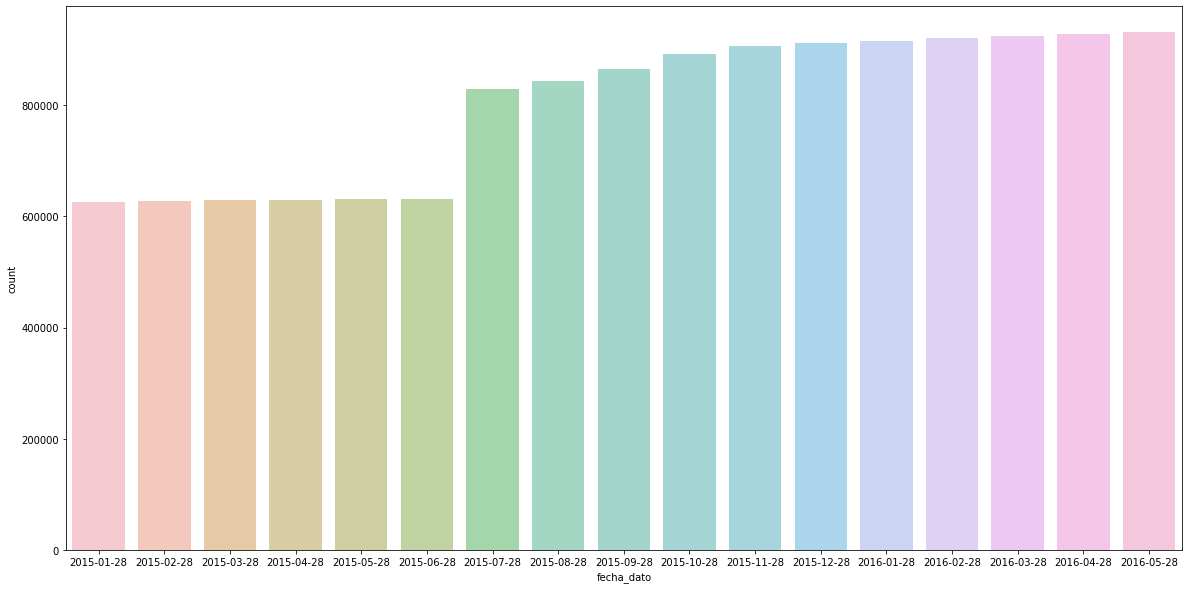

--------------------------------------------------
col:  ind_empleado


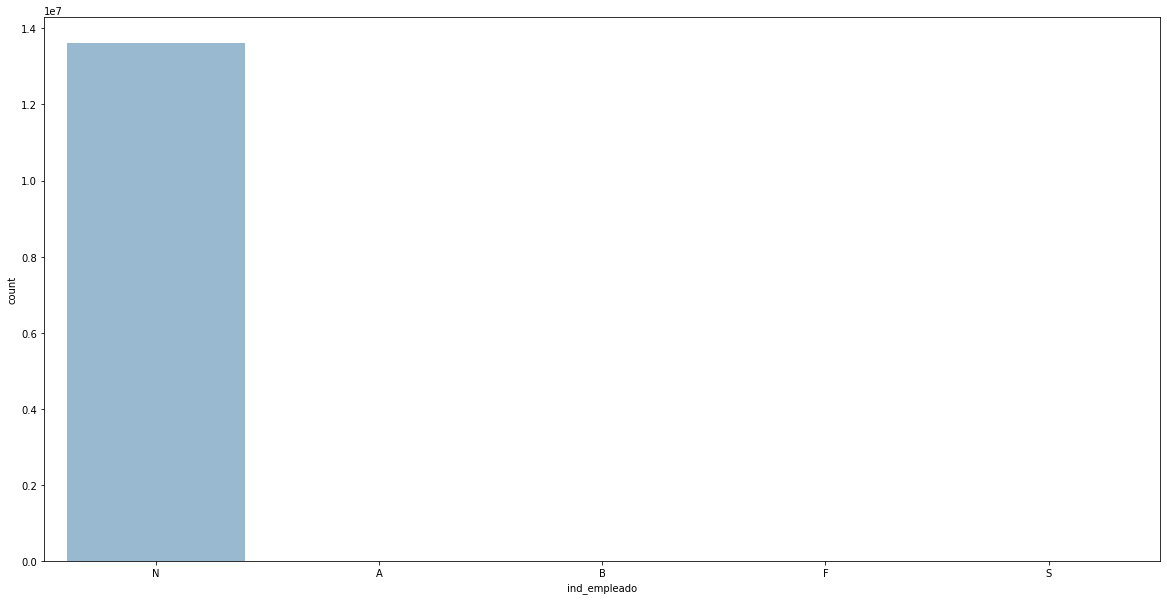

--------------------------------------------------
col:  pais_residencia


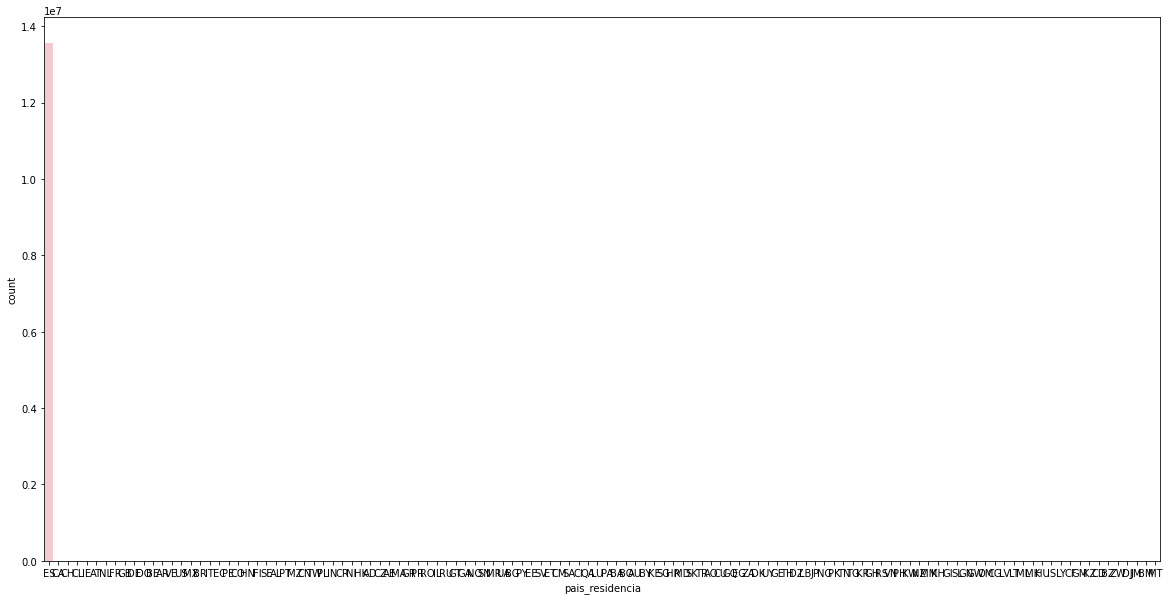

--------------------------------------------------
col:  sexo


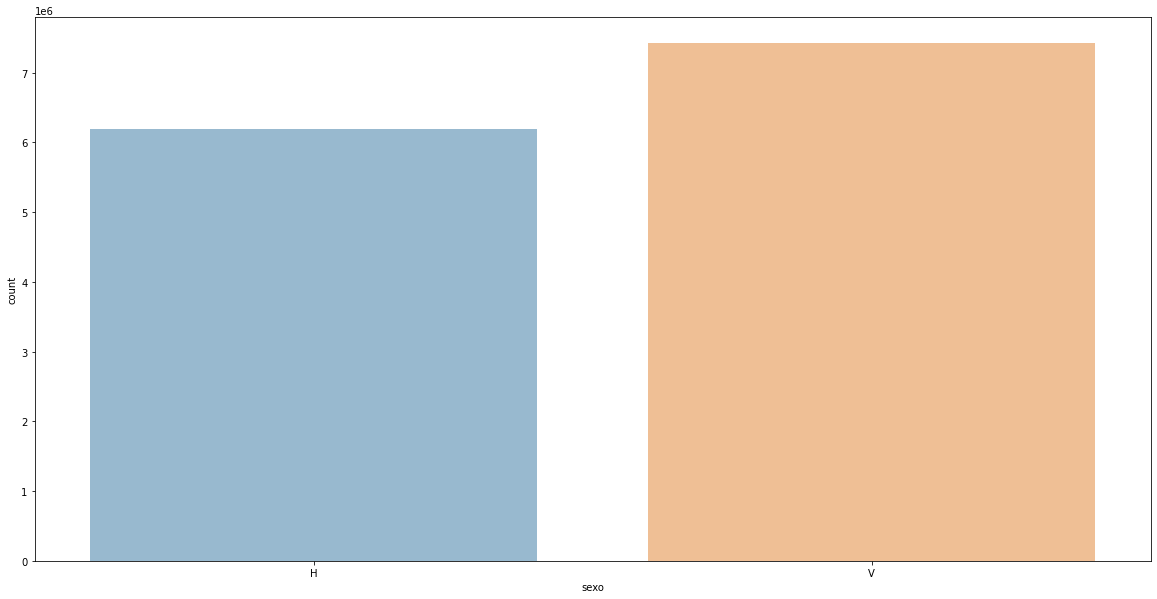

--------------------------------------------------
col:  age


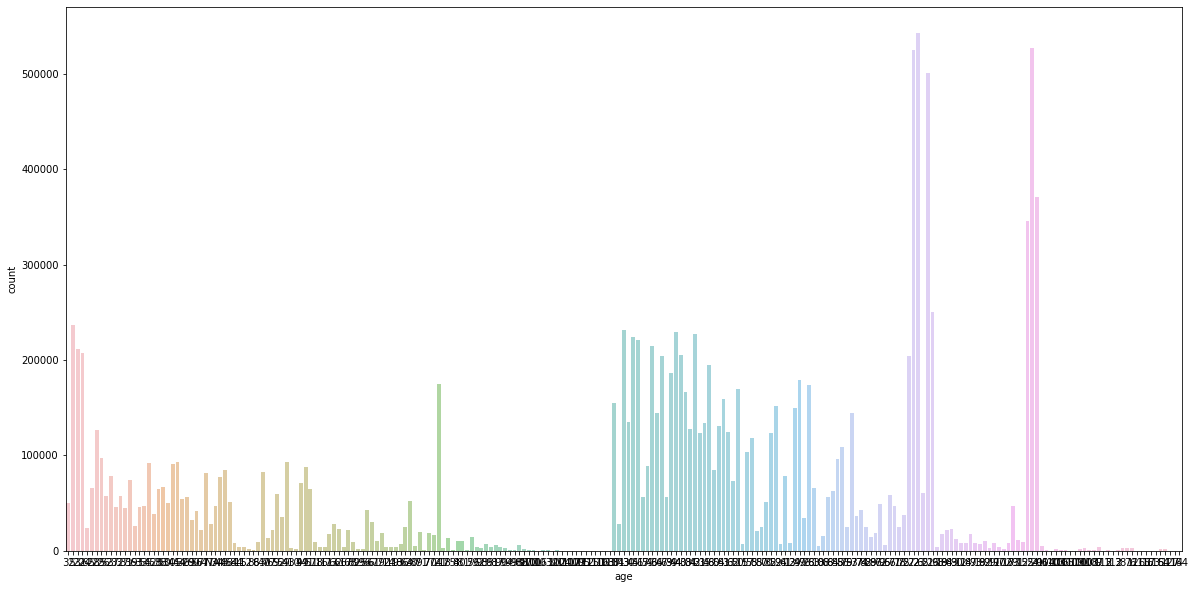

--------------------------------------------------
col:  fecha_alta


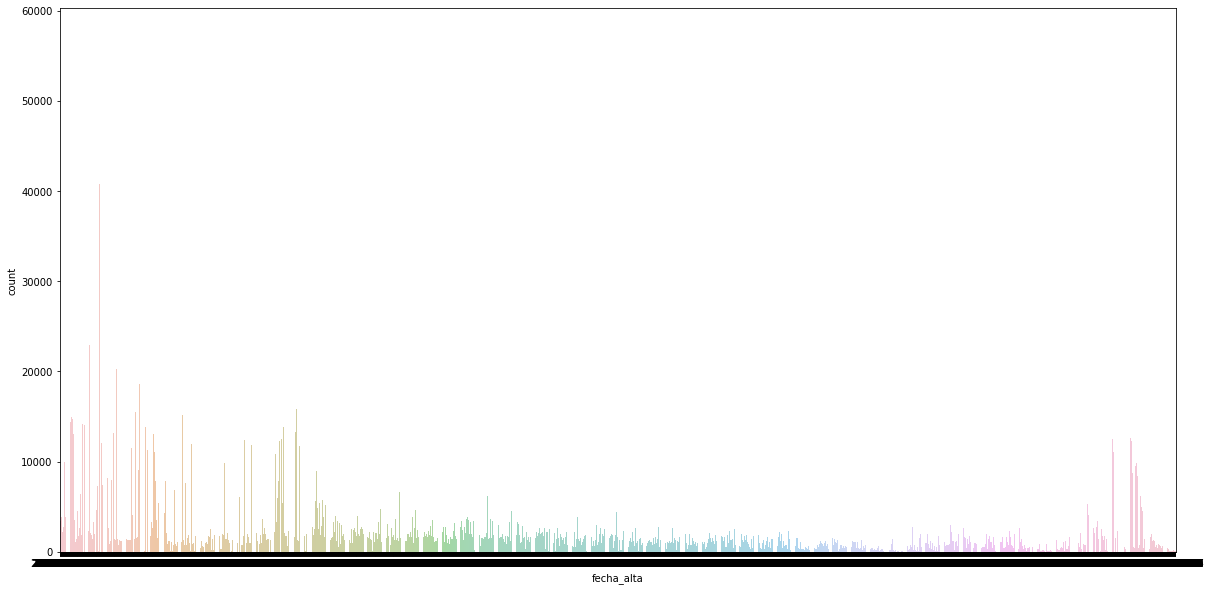

--------------------------------------------------
col:  ind_nuevo


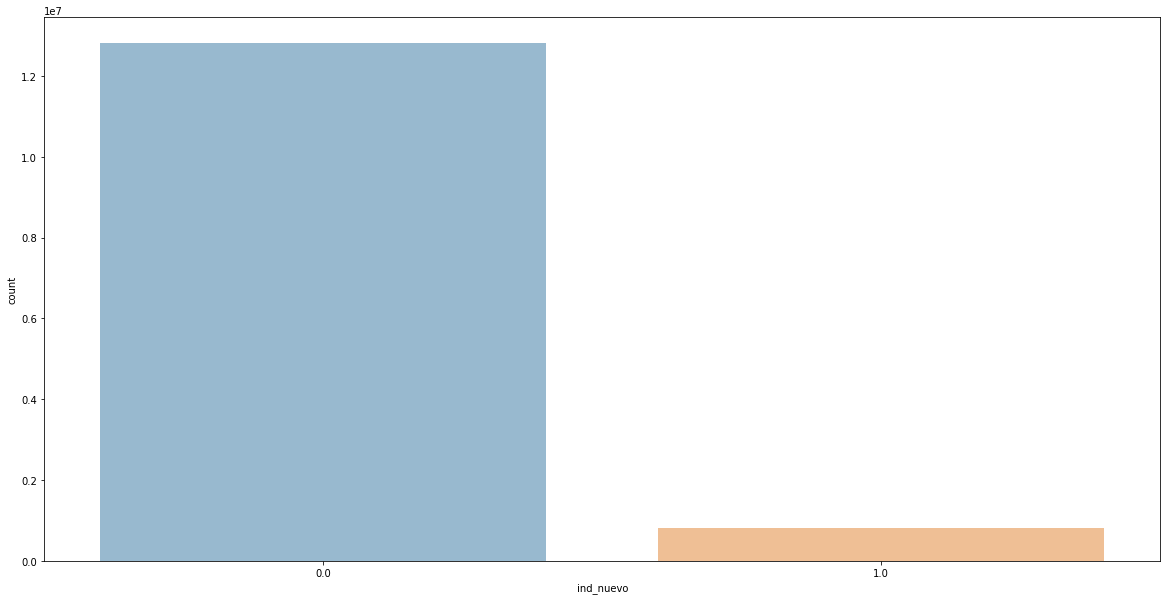

--------------------------------------------------
col:  antiguedad


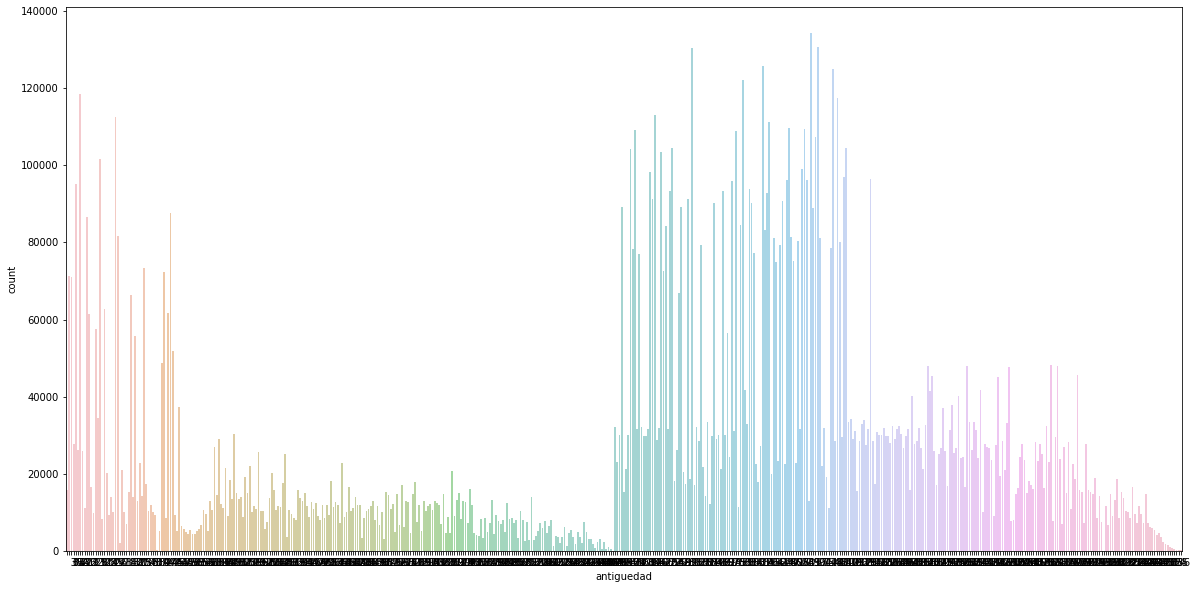

--------------------------------------------------
col:  indrel


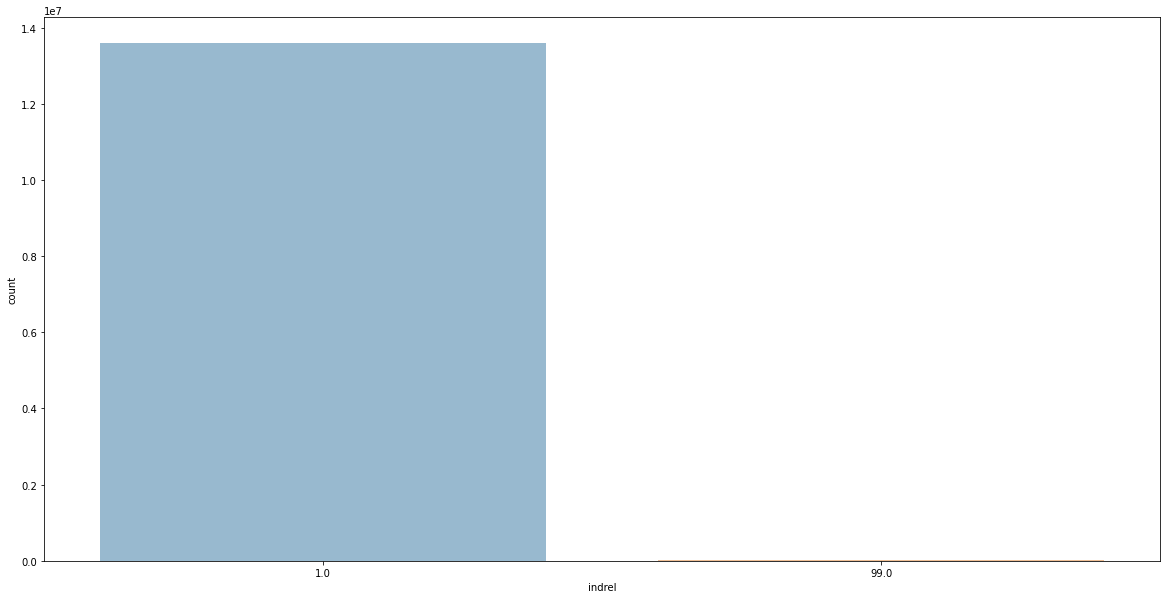

--------------------------------------------------
col:  ult_fec_cli_1t


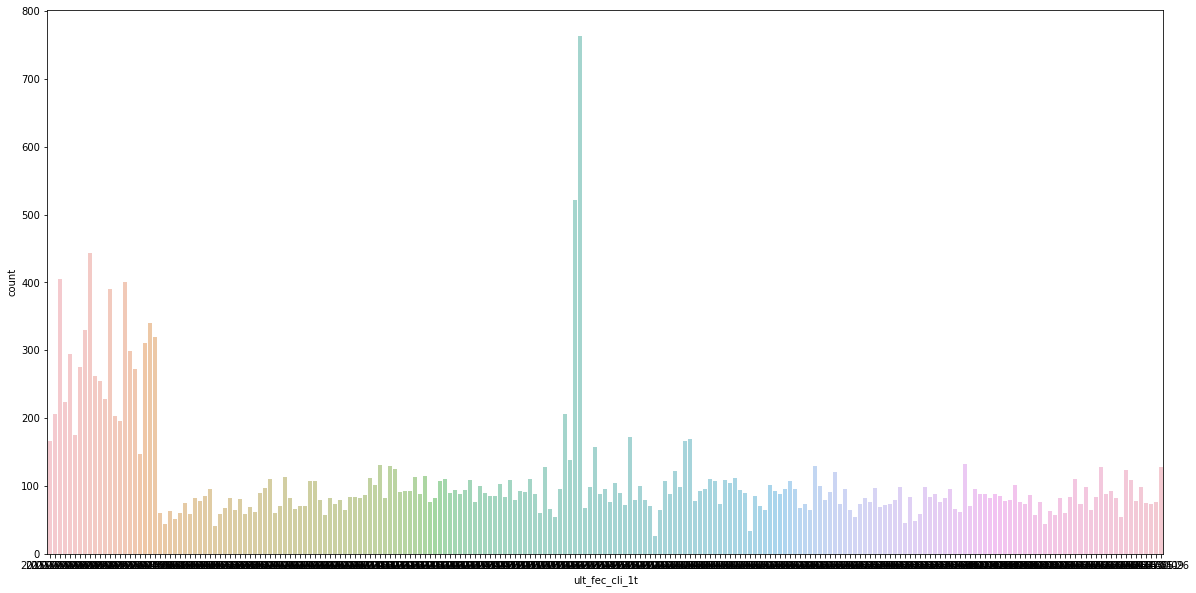

--------------------------------------------------
col:  indrel_1mes


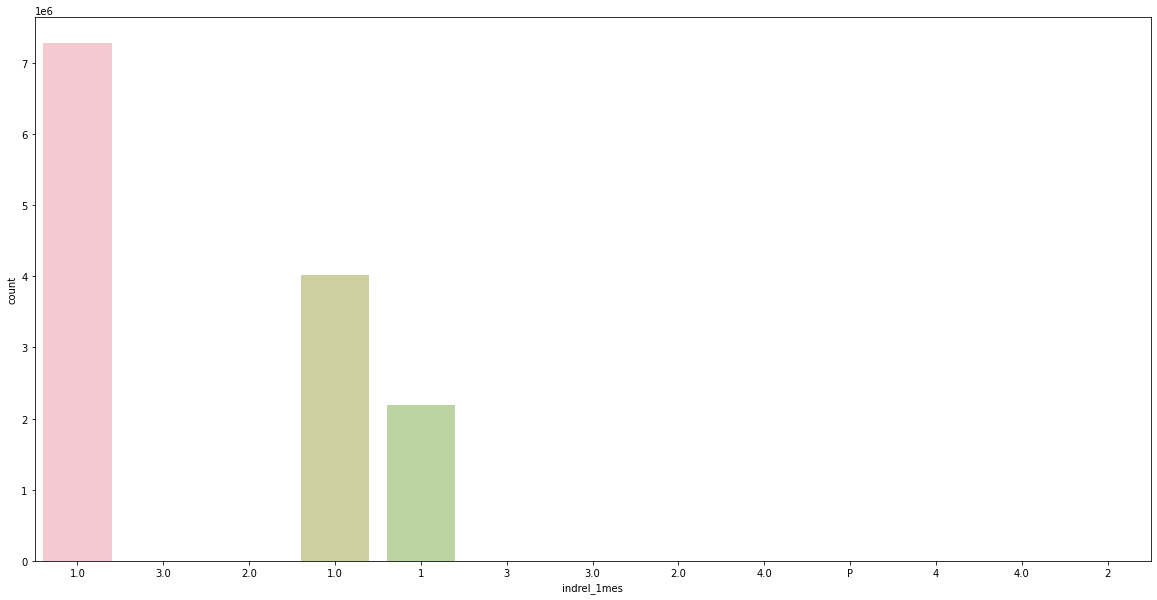

--------------------------------------------------
col:  tiprel_1mes


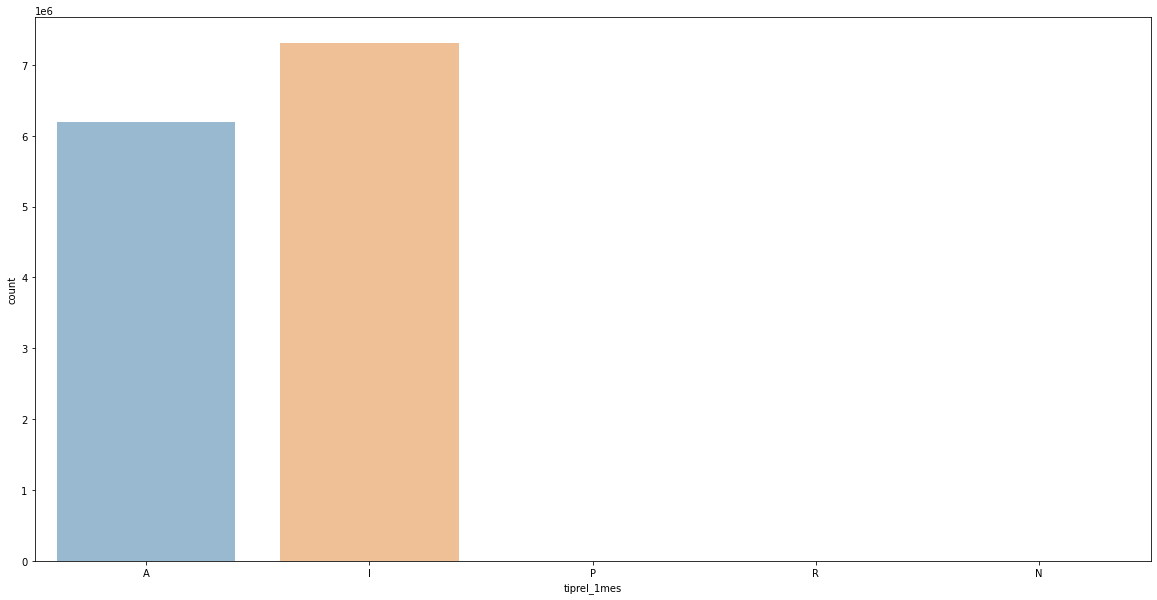

--------------------------------------------------
col:  indresi


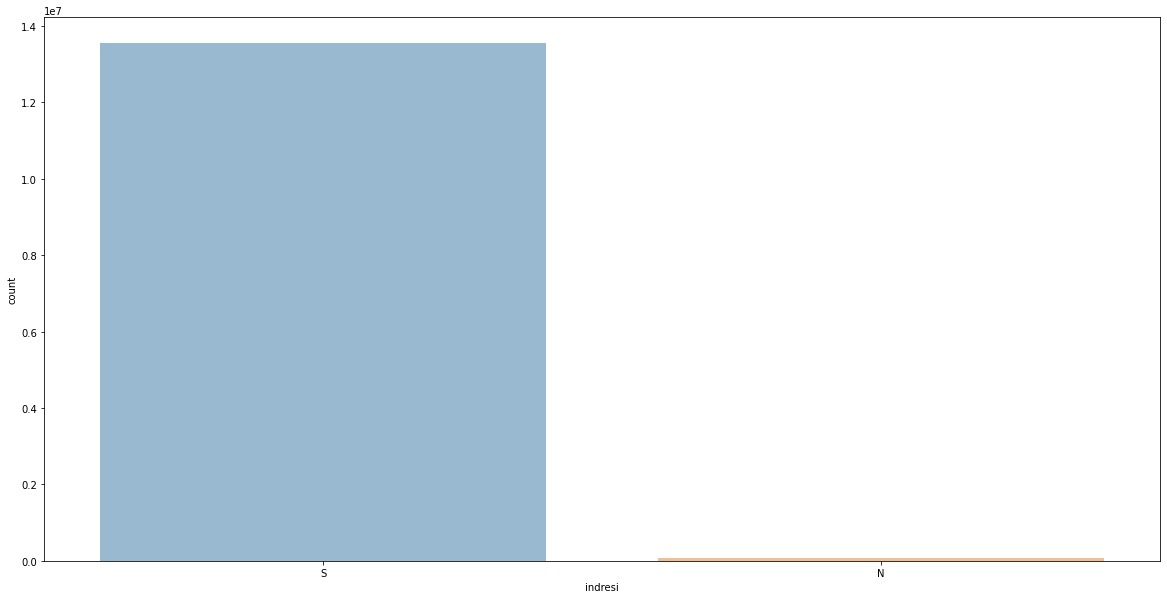

--------------------------------------------------
col:  indext


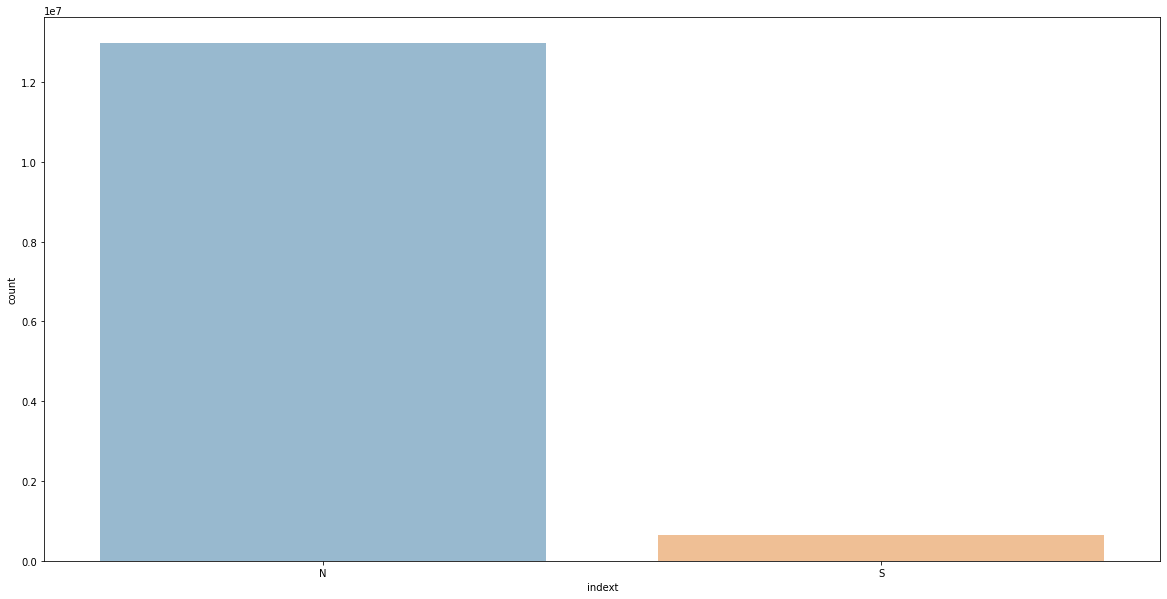

--------------------------------------------------
col:  conyuemp


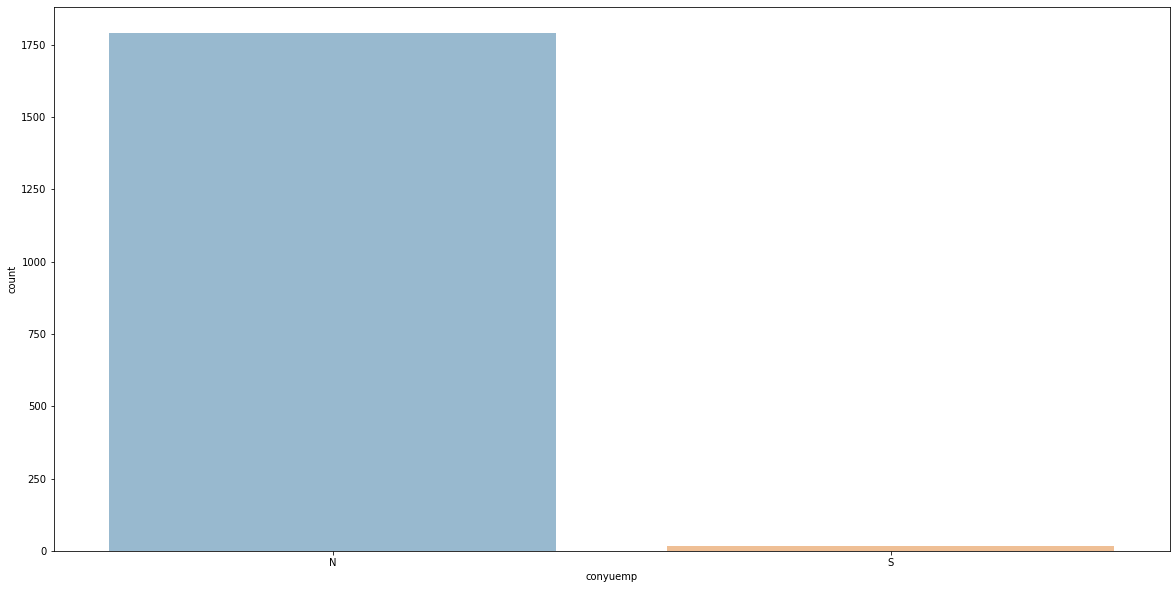

--------------------------------------------------
col:  canal_entrada


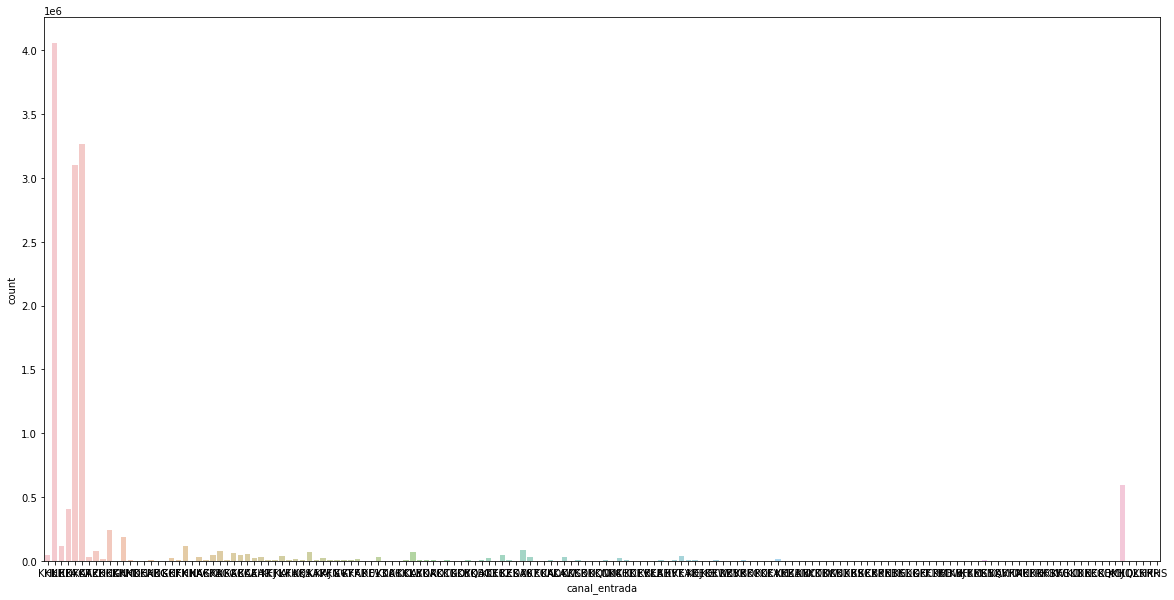

--------------------------------------------------
col:  indfall


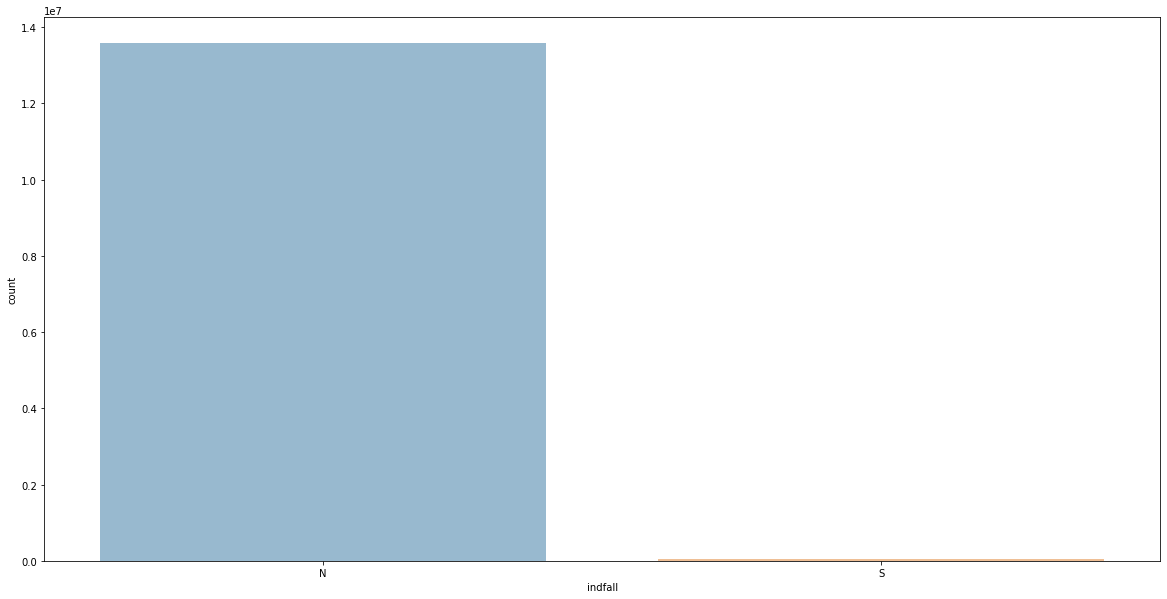

--------------------------------------------------
col:  tipodom


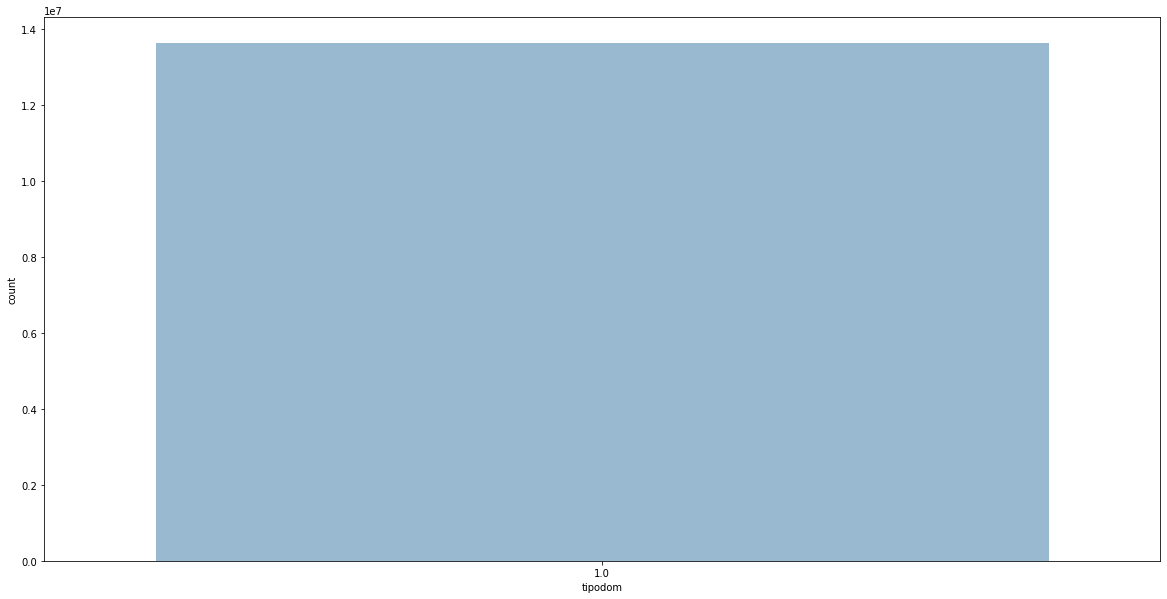

--------------------------------------------------
col:  cod_prov


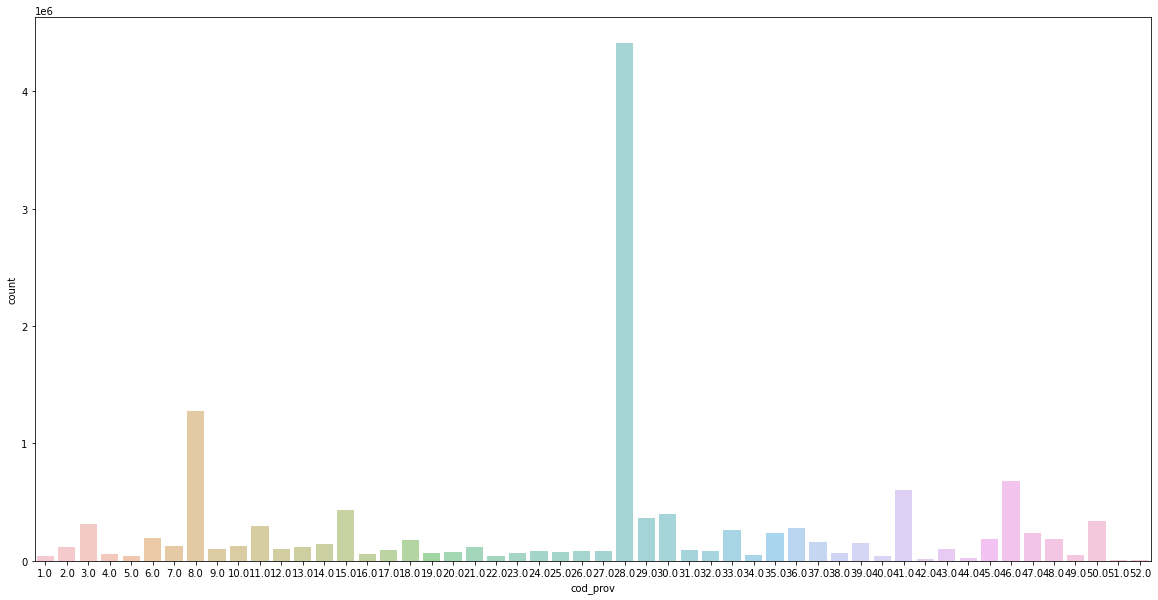

--------------------------------------------------
col:  nomprov


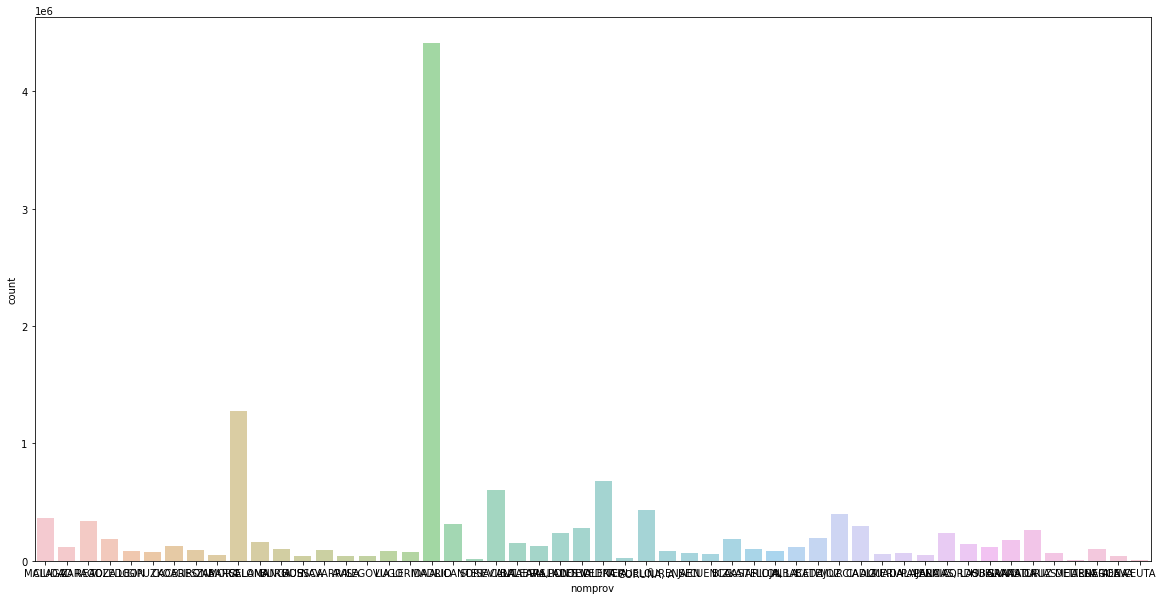

--------------------------------------------------
col:  ind_actividad_cliente


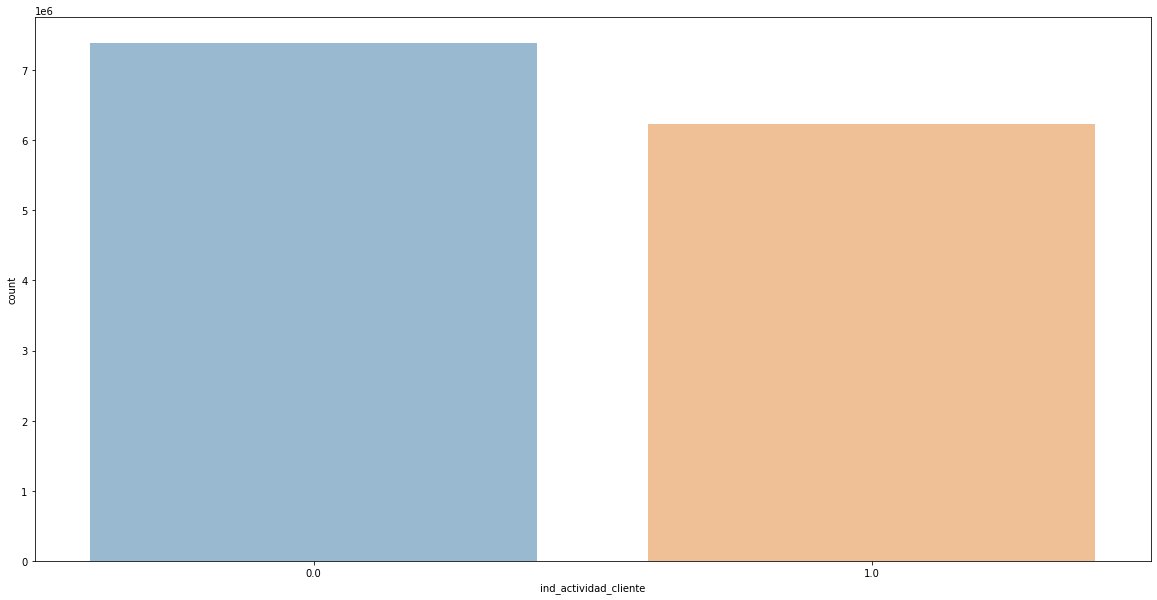

--------------------------------------------------
col:  segmento


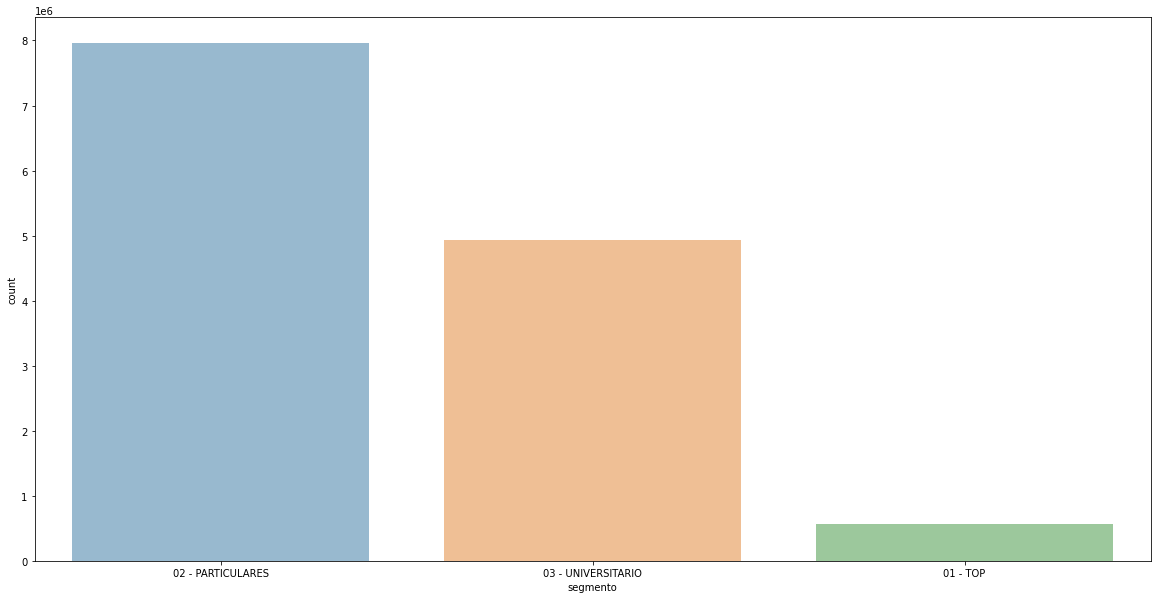

--------------------------------------------------
col:  ind_ahor_fin_ult1


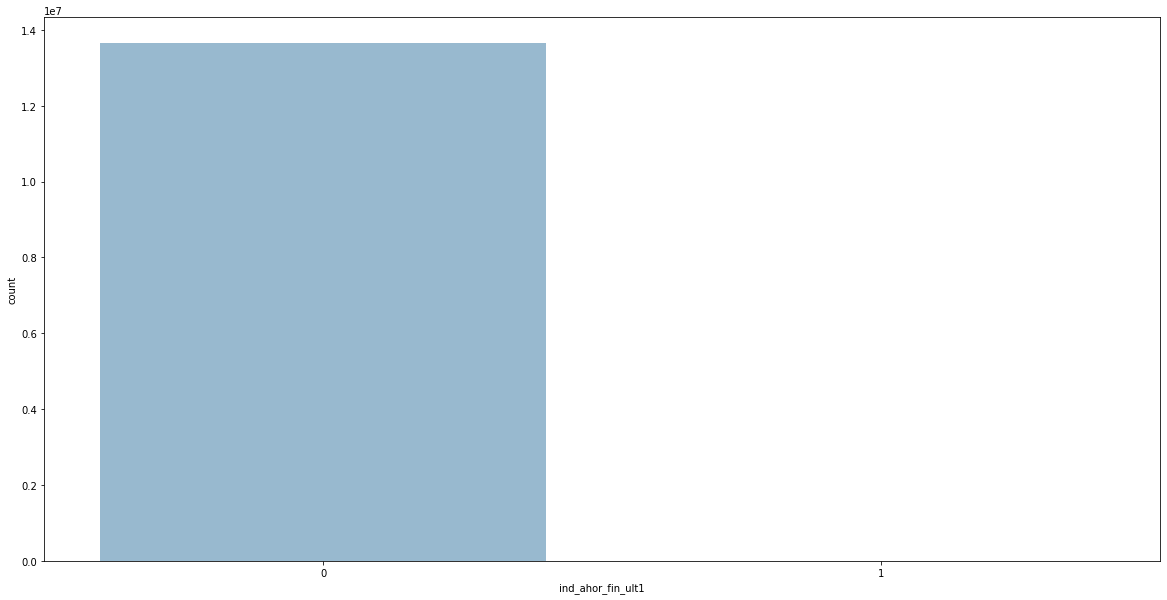

--------------------------------------------------
col:  ind_aval_fin_ult1


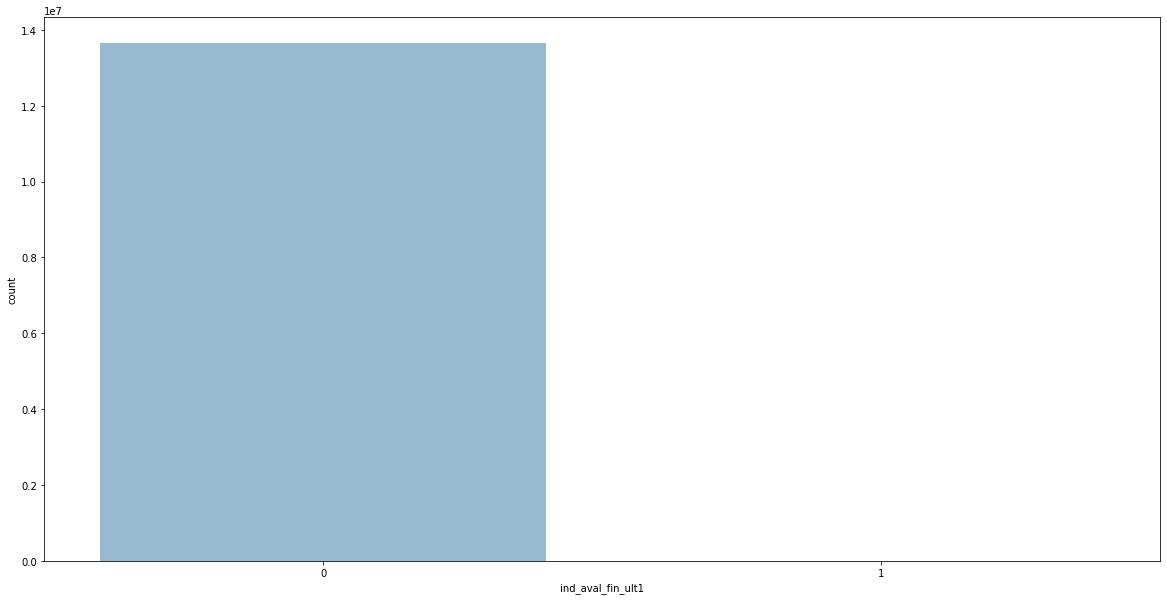

--------------------------------------------------
col:  ind_cco_fin_ult1


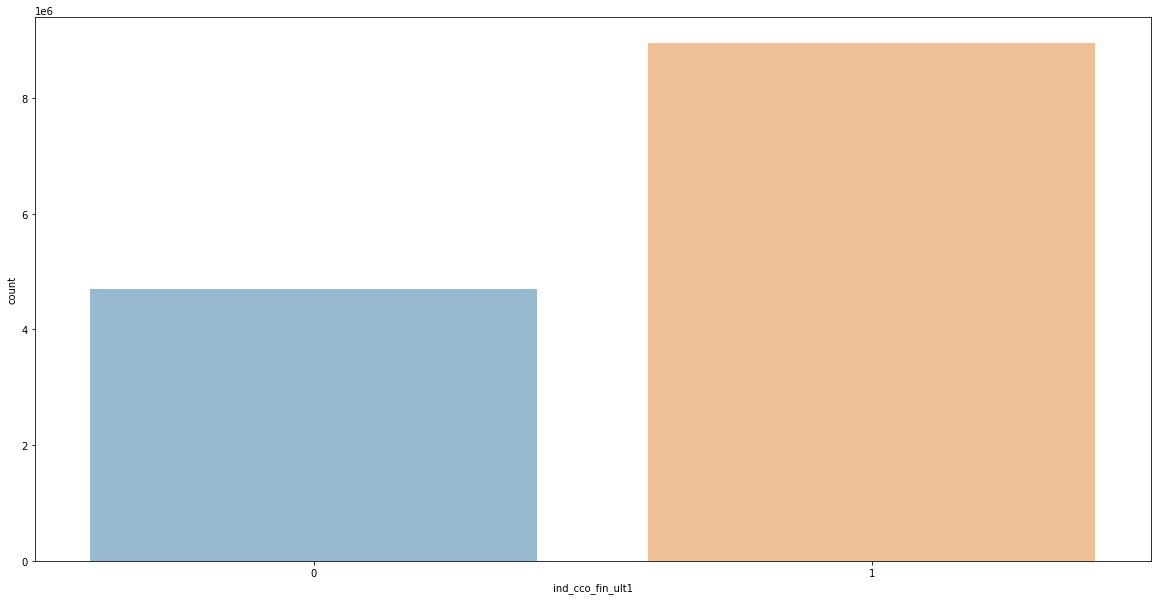

--------------------------------------------------
col:  ind_cder_fin_ult1


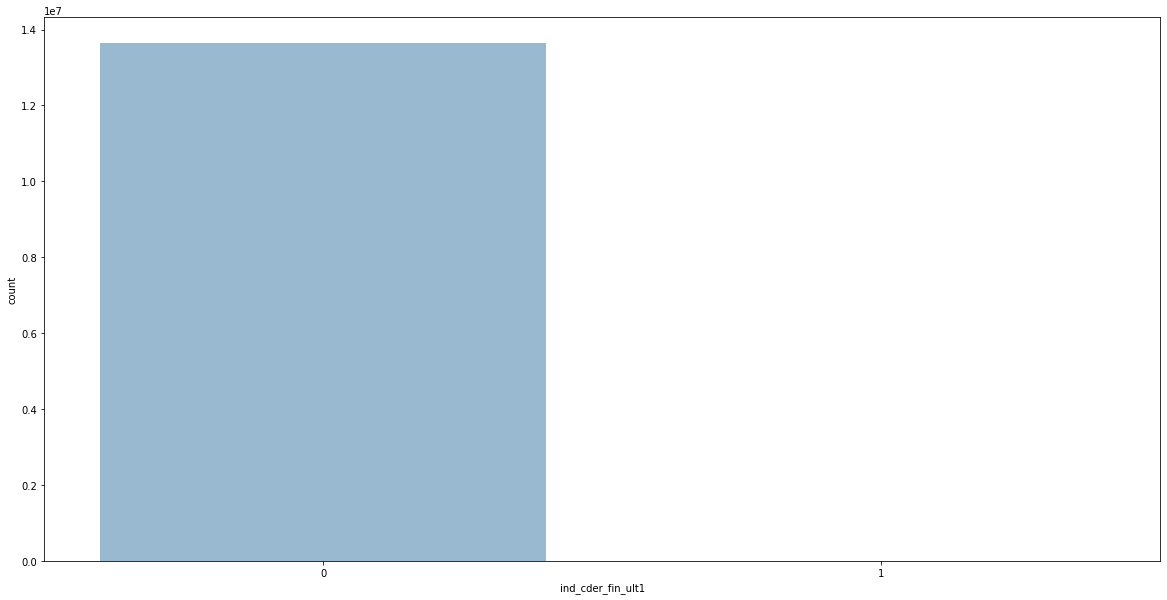

--------------------------------------------------
col:  ind_cno_fin_ult1


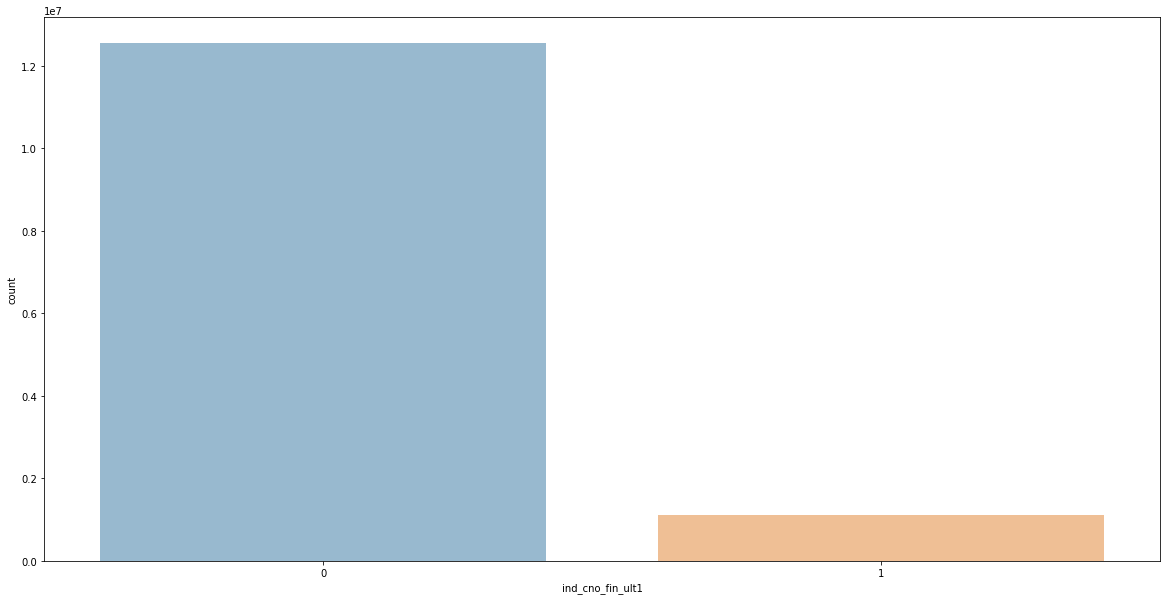

--------------------------------------------------
col:  ind_ctju_fin_ult1


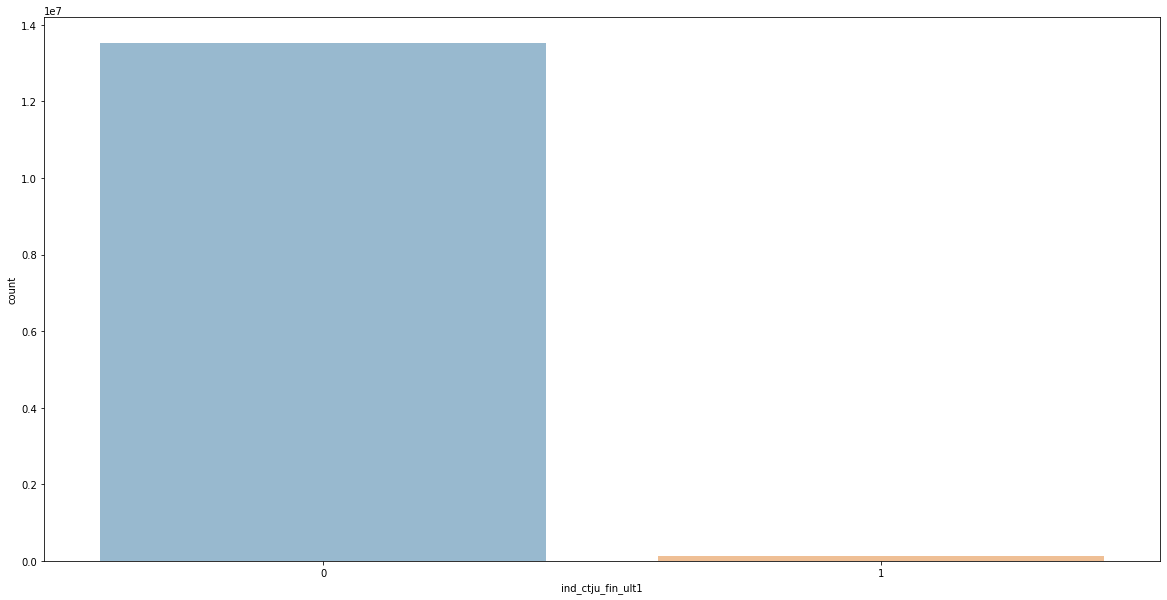

--------------------------------------------------
col:  ind_ctma_fin_ult1


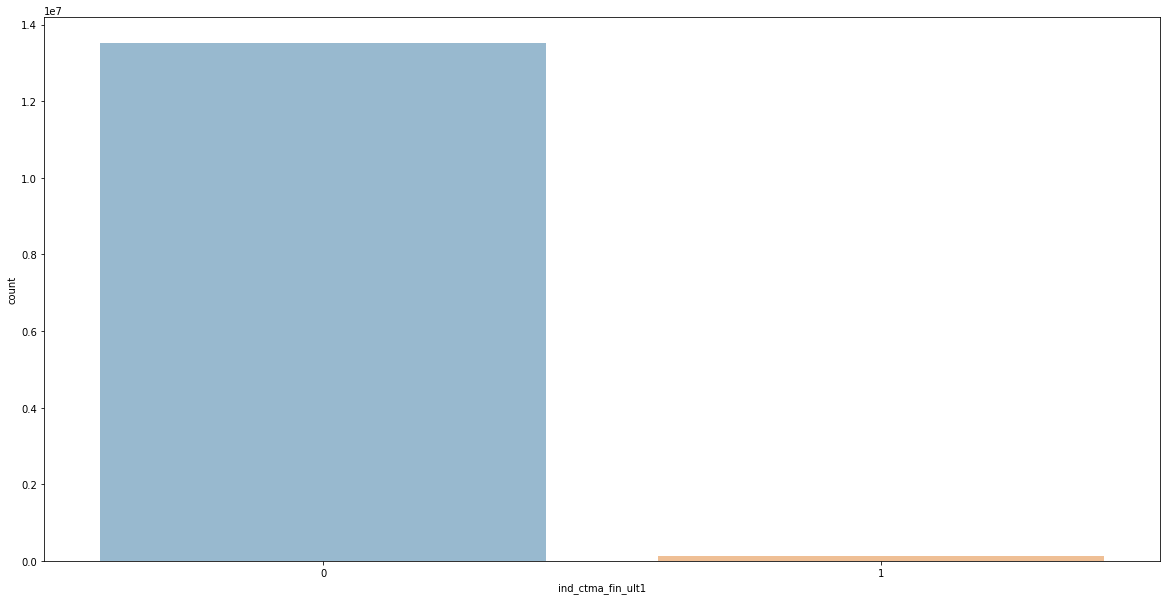

--------------------------------------------------
col:  ind_ctop_fin_ult1


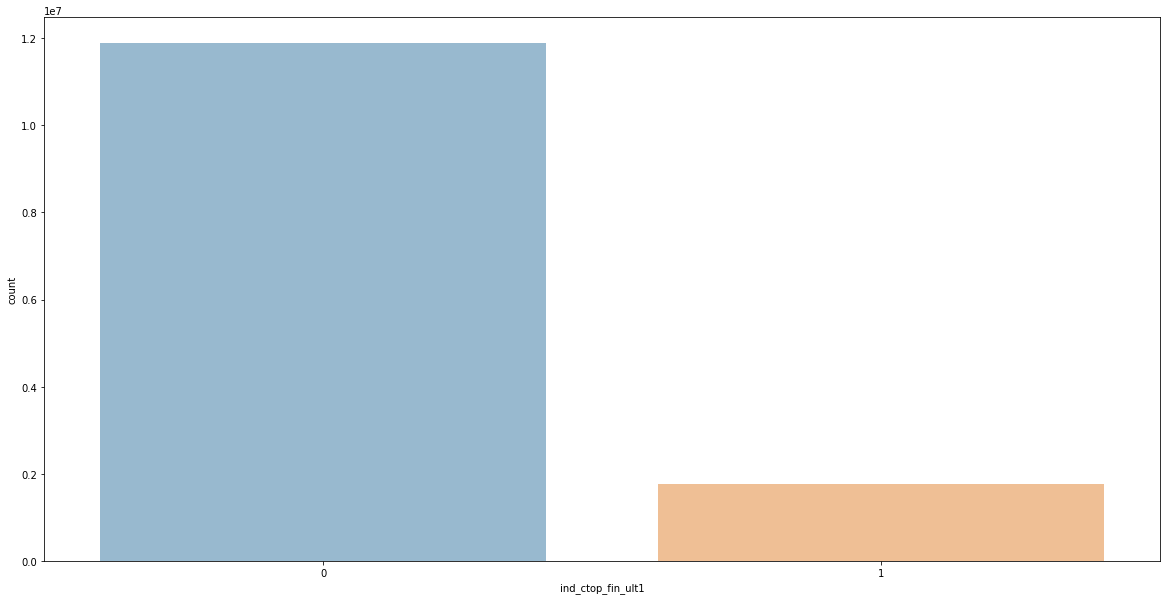

--------------------------------------------------
col:  ind_ctpp_fin_ult1


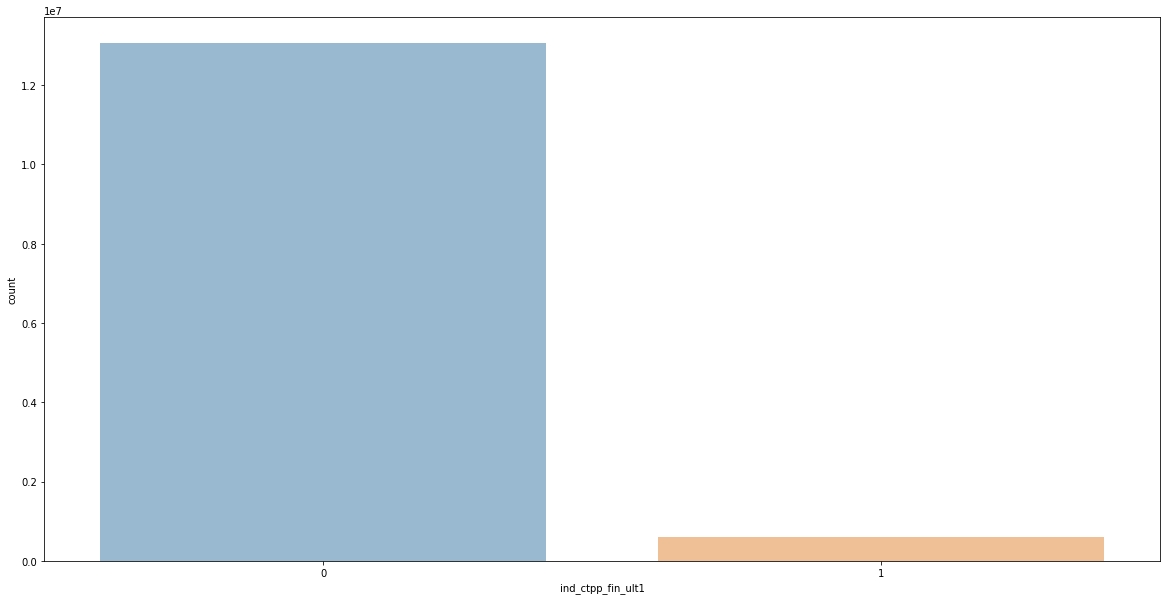

--------------------------------------------------
col:  ind_deco_fin_ult1


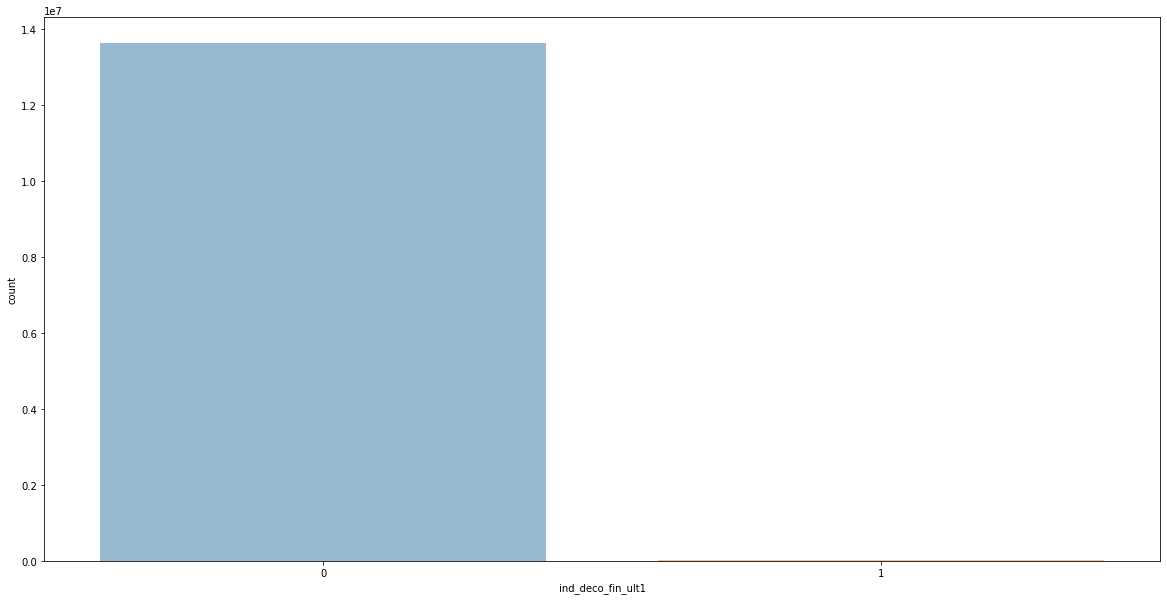

--------------------------------------------------
col:  ind_deme_fin_ult1


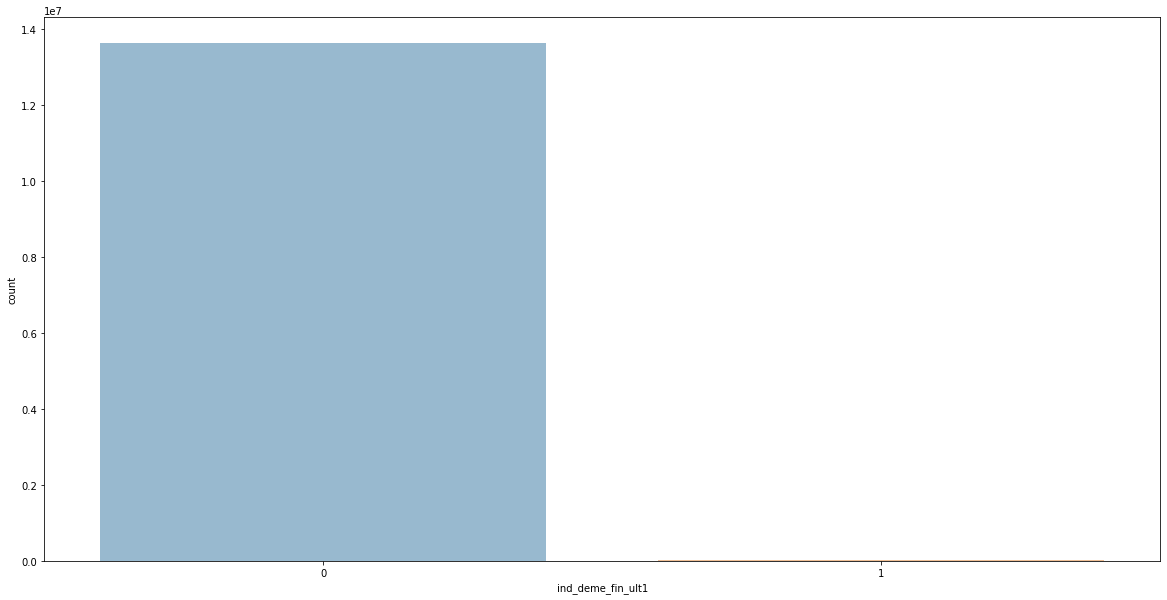

--------------------------------------------------
col:  ind_dela_fin_ult1


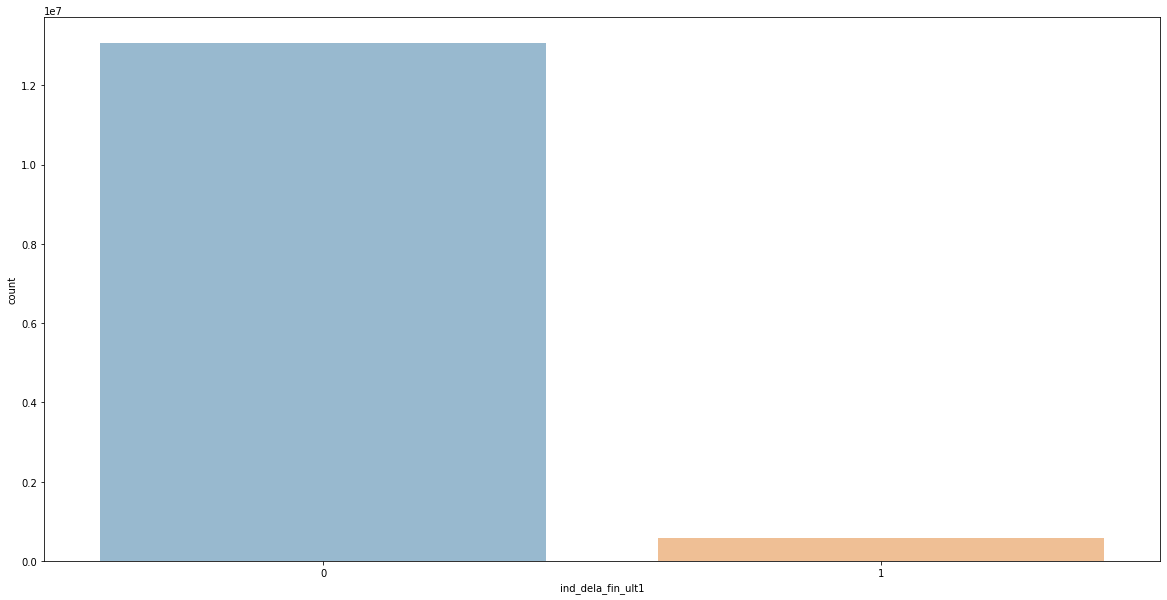

--------------------------------------------------
col:  ind_ecue_fin_ult1


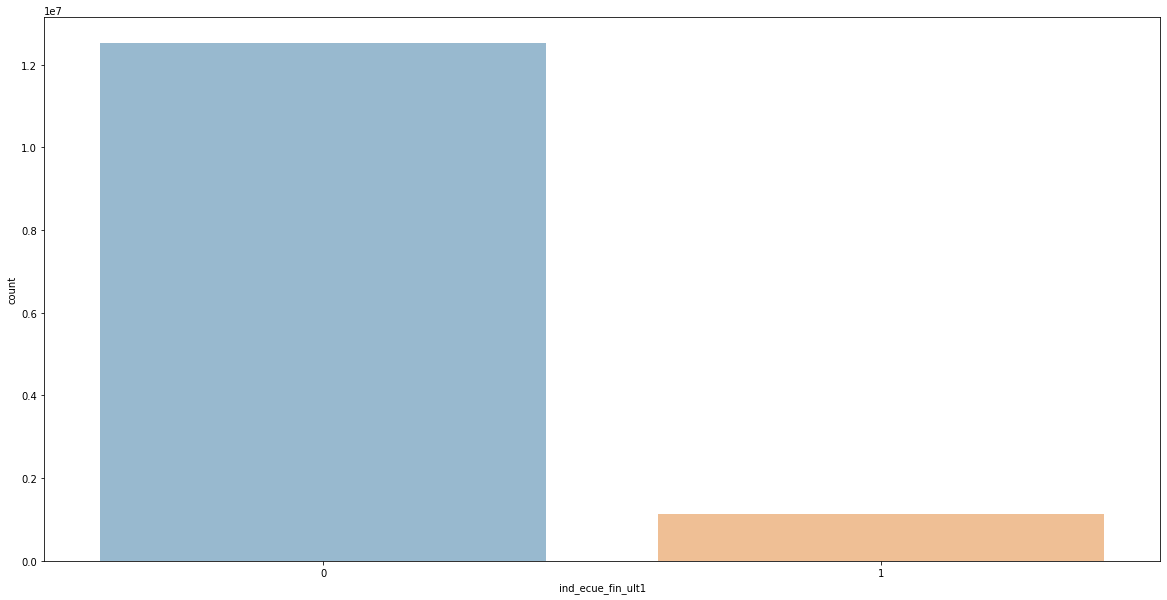

--------------------------------------------------
col:  ind_fond_fin_ult1


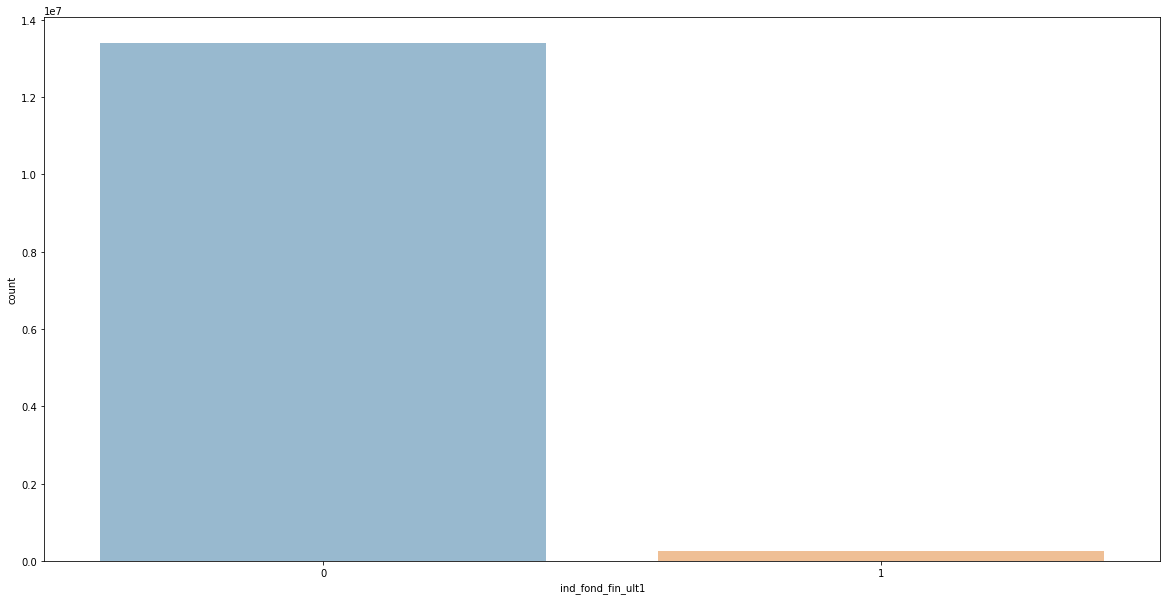

--------------------------------------------------
col:  ind_hip_fin_ult1


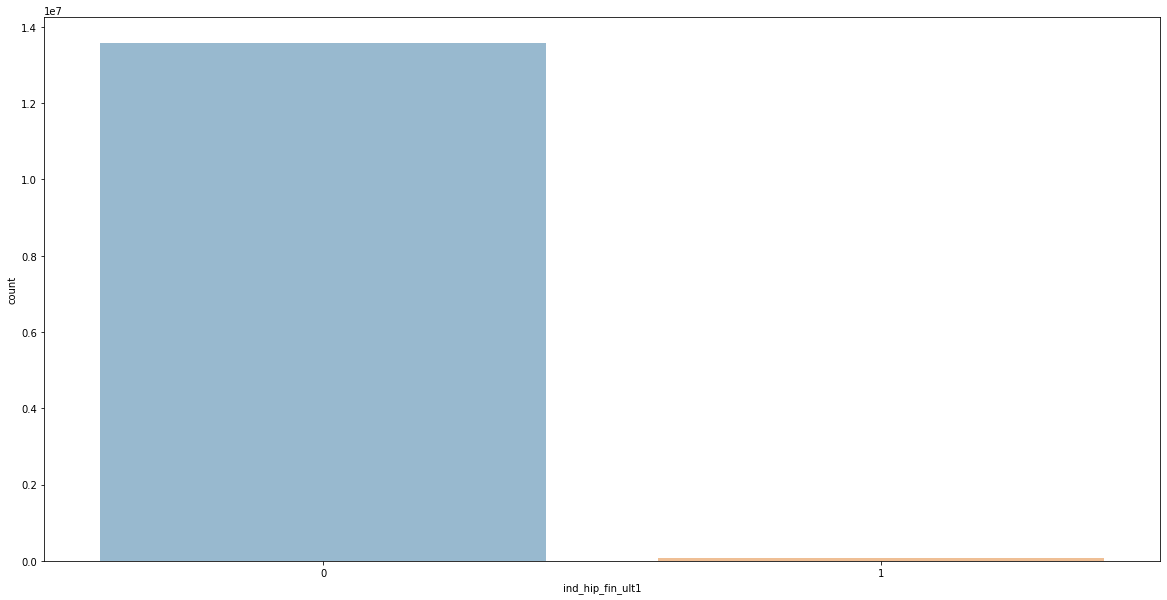

--------------------------------------------------
col:  ind_plan_fin_ult1


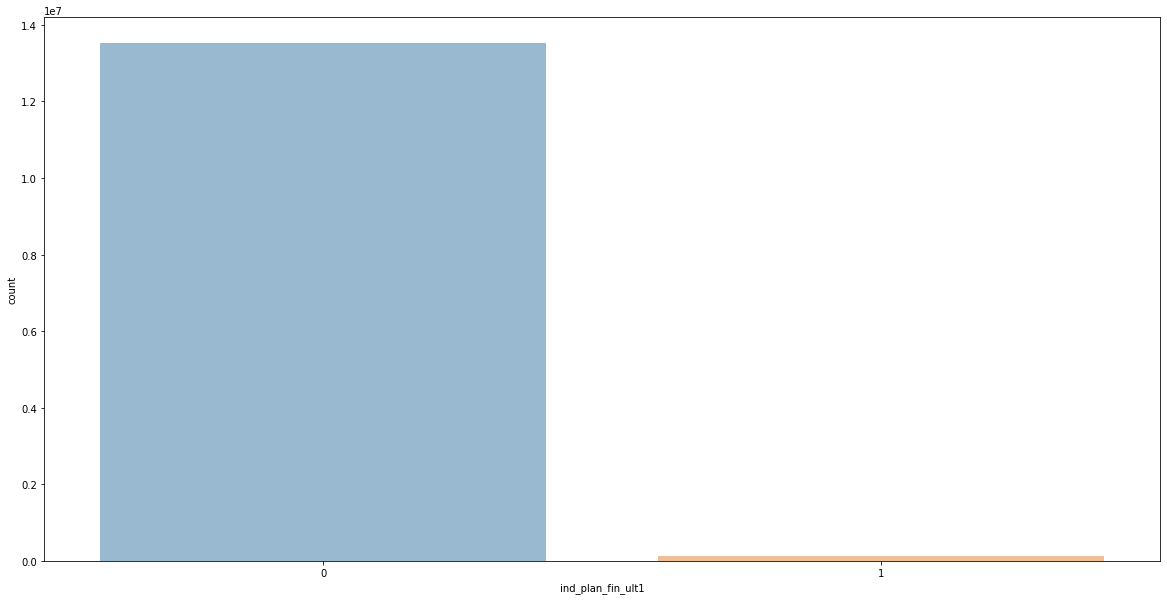

--------------------------------------------------
col:  ind_pres_fin_ult1


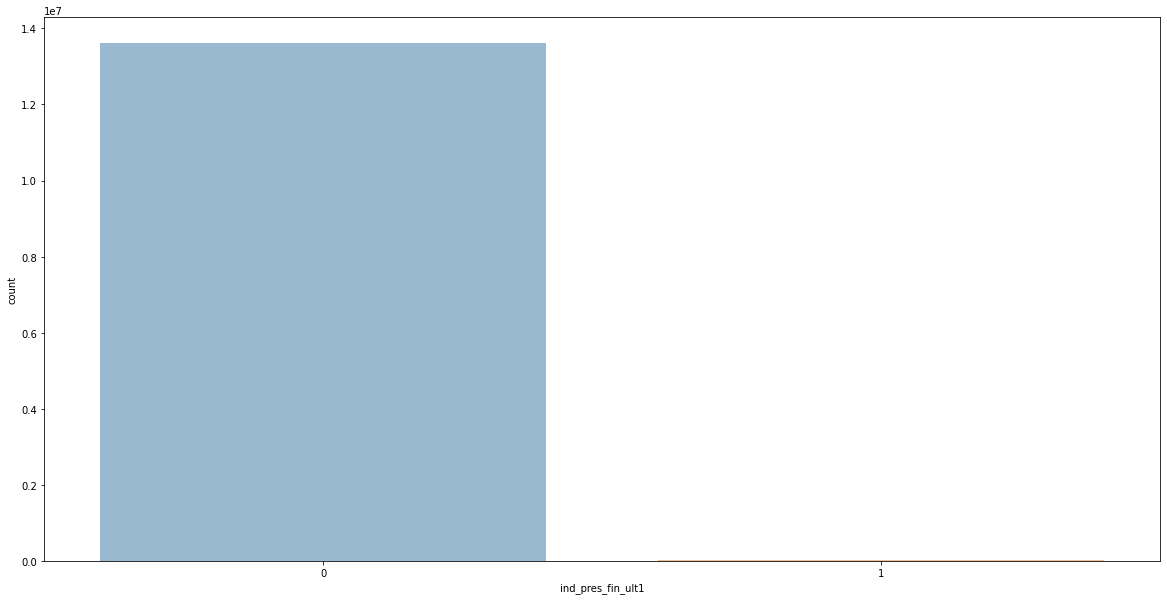

--------------------------------------------------
col:  ind_reca_fin_ult1


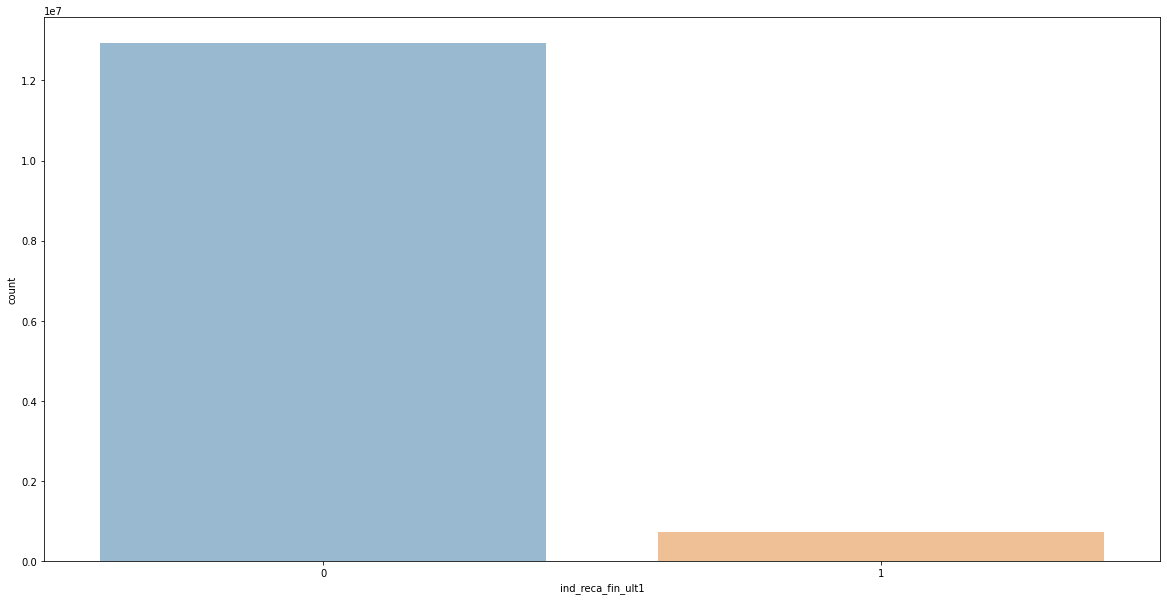

--------------------------------------------------
col:  ind_tjcr_fin_ult1


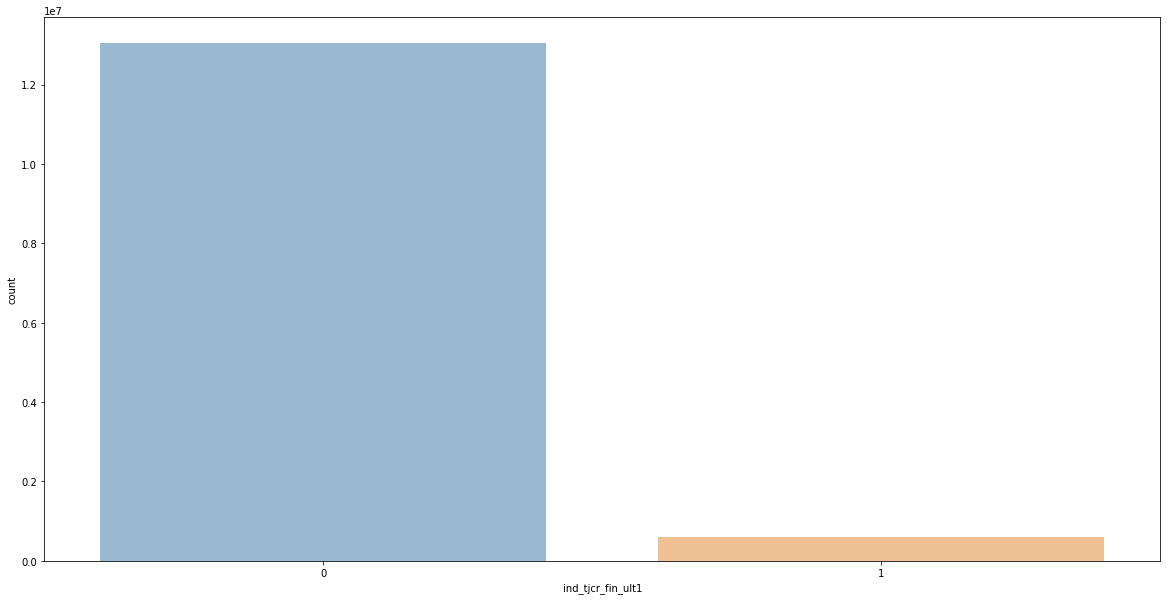

--------------------------------------------------
col:  ind_valo_fin_ult1


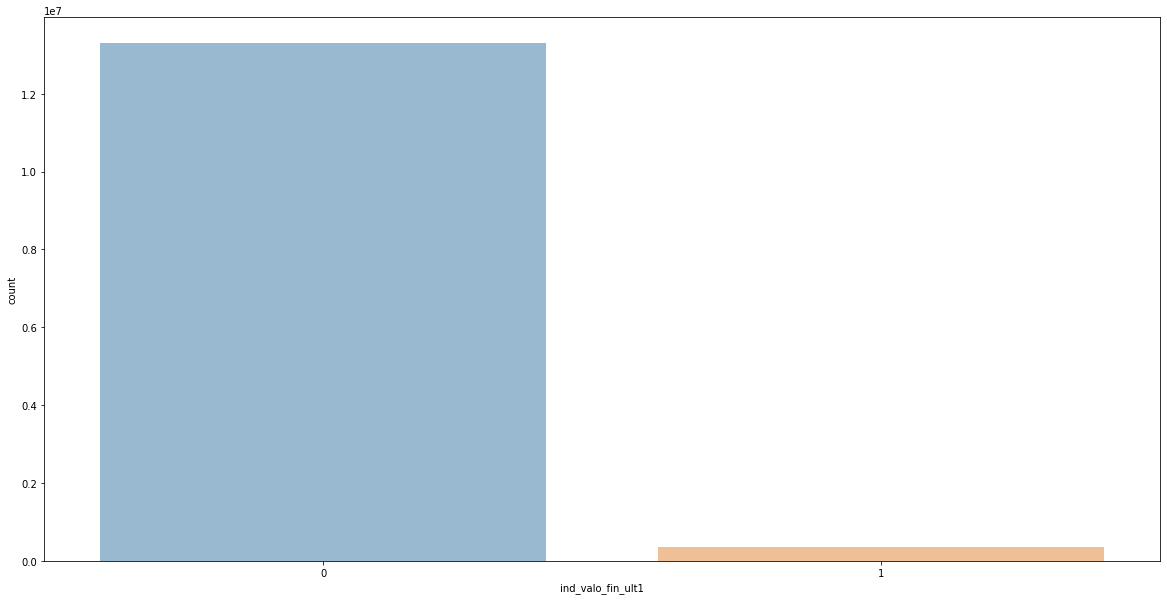

--------------------------------------------------
col:  ind_viv_fin_ult1


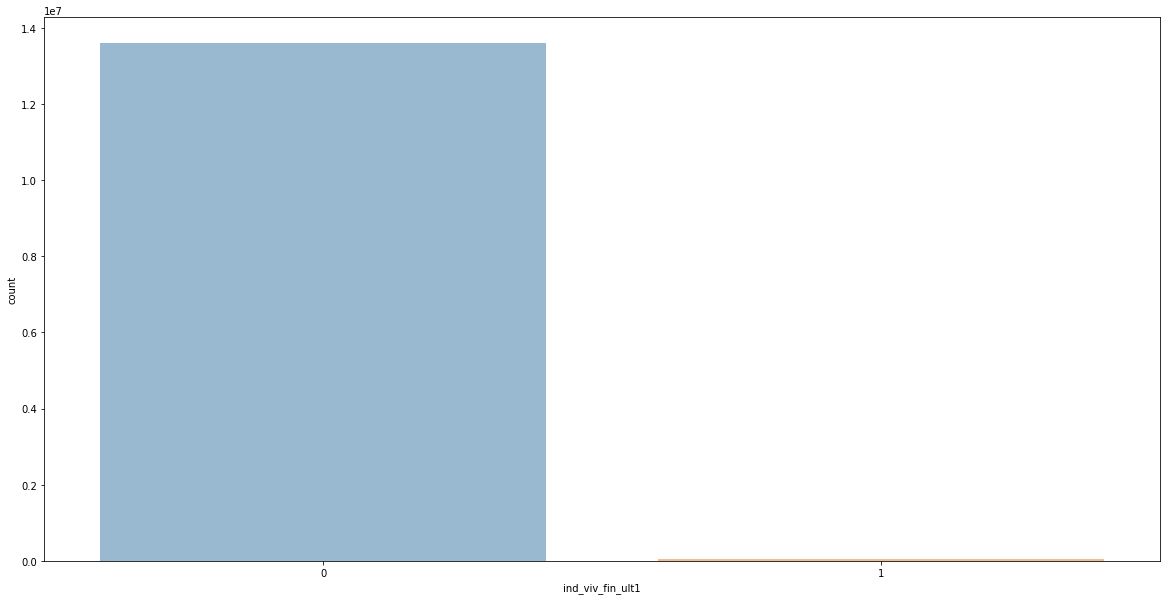

--------------------------------------------------
col:  ind_nomina_ult1


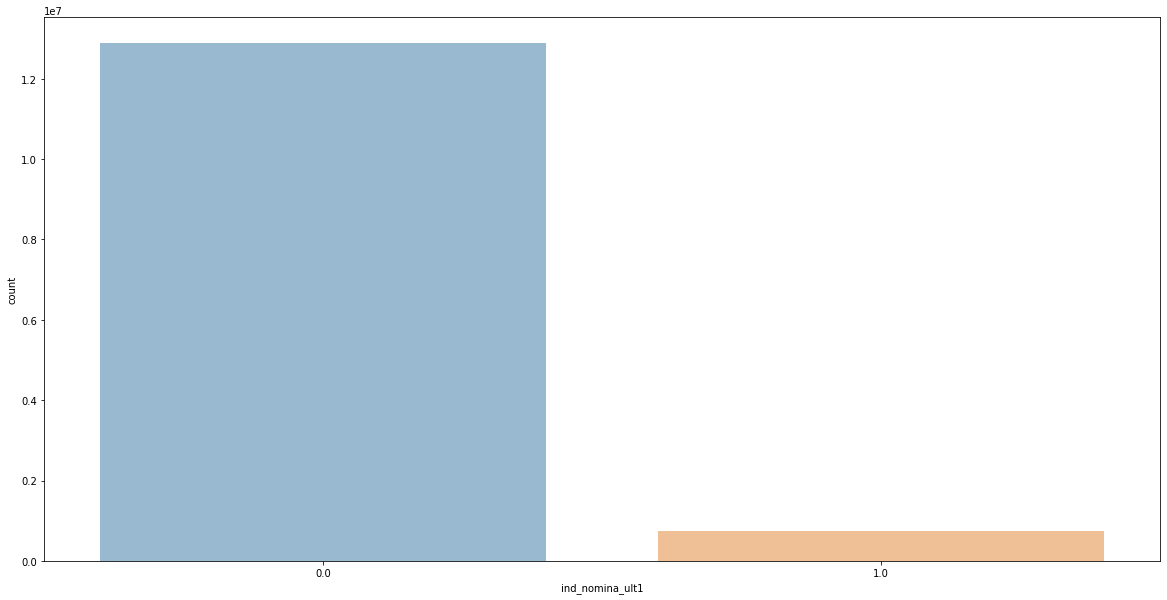

--------------------------------------------------
col:  ind_nom_pens_ult1


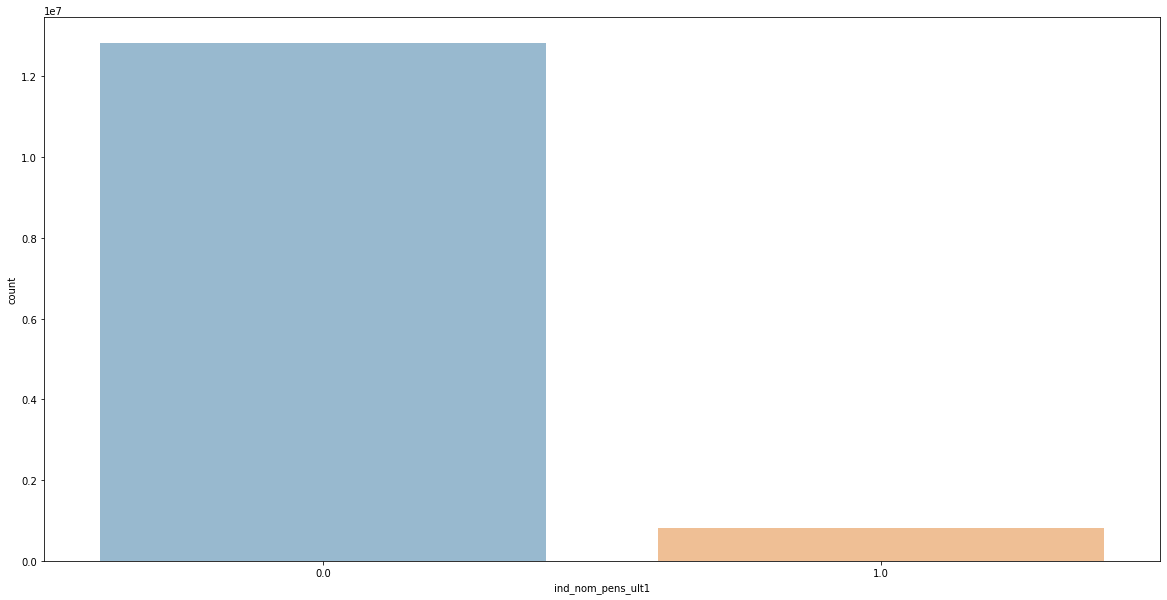

--------------------------------------------------
col:  ind_recibo_ult1


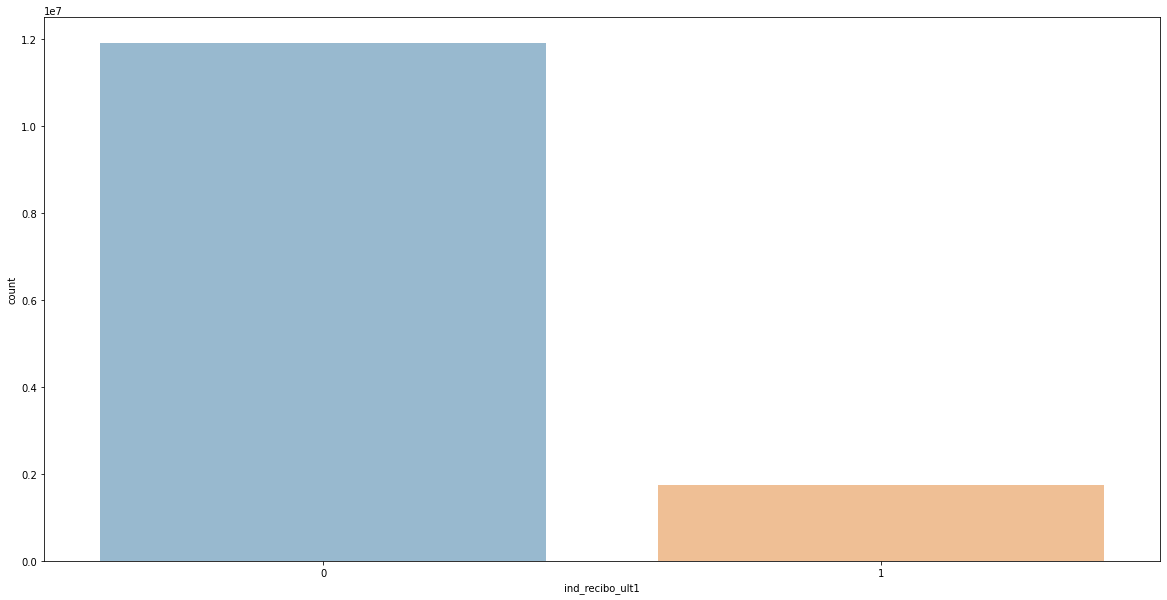

In [ ]:
# 시각화하기
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# ncoders와 renta의 변수는 고유값이 너무많아 시각화하는데 어려움이 있음
skip_cols = ['ncodpers', 'renta']

# histogram을 plotting함
# 제품변수 24개와 고객변수 24개의 총 48개의 변수중 ncodpers와 renta를 제외
for col in train.columns:
  if col in skip_cols:
    continue
  
  # 보기 편하게 영역을 구분하고 변수명을 출력함
  print('-' * 50)
  print('col: ', col)

  # 그래프의 figsize를 결정
  f, ax = plt.subplots(figsize = (20, 10))
  
  # seaborn을 이용한 막대그래프를 생성
  sns.countplot(x = col, data = train, alpha = 0.5)

  # show함수를 통한 시각화
  plt.show()

### 시각화 결과정리
* fecha_dato: 2015-01-28 ~ 2015-06-28의 첫 6개월은 고객 데이터 개수가 같고 그 이후에 증가함
* indrel_1mes: 월초 기준 고객 등급을 의미하는 변수는 수치형(1,2,3,4)와 범주형(P)값이 섞여 있는 변수임. 그러나 막대그래프에서는 (1.0, 1)이 서로 다른 값인 것 처럼 표기가 되는 이것은 데이터 타입이 object이기 때문임. 전처리에서 모두 1로 통일할 것
* age, antiguedad: 수치형 변수인 나이 분포가 중간에 뚝 끊긴 양상을 보이는데 이는 object형태로 저장된 indrel_1mes변수와 같은 문제임
* fecha_alta: 1995년부터 2016년까지 폭 넓은 값을 가지는 날짜 데이터임. 1995년과 2016년의 빈도가 높은 것을 통해 장기고객과 신규고객의 비율이 높아보임
* ind_nuevo: 이진 변수(0,1)로 표기되는 방식이고 신규 고객 지표이다(6개월 이내 = 1). 대부분이 0이고 1은 가끔 존재
* indrel: 고객 등급 지표인데, 99는 해당달에 1등급이 해제되는 등급의 고객이다. 대부분은 1이고 소수가 99인 변수이다. -> 정수로 변환할 필요가 있음
* ult_fec_cli_it: 1등급 고객의 마지막 날짜이다. object형 변수이고 2015.07 ~ 2016.05
* tiprel_1mes: 월초 기준 고객 관계 유형 A: active I: inactive, P: former customer, R: potential 이고 object형 변수이고 A, I의 빈도가 높다
* indresi: 거주지표 은행이 위치한 국가와 동일한가 아닌가 s: yes n: no 이고 object 변수형 S의 빈도가 높음
* indext: 외국인 지표로 태어난 국가와 은행이 위치한 국가가 같으면 S 다르면 N 이고 object 데이터 타입이다.
* conyuemp: 배우자가 은행 직원이면 1 아니면 N 이고 N의 빈도가 높은 object 데이터 타입이다.
* canal_entrada: 고객 유입 채널이고 object 데이터 타입인데 알파벳 세글자로 암호화된 유입경로 변수이다.
* indfall: 고객의 사망여부로 S는 사망한 경우 N은 사망하지 않은 경우이다.
* tipodom: 주소 유형으로 모든 값이 1인데 변수로 무의미함.
* nomprov: 지방 이름이고 데이터 타입은 object로 스페인 지역이름을 나타낸다 cod_prov와 동일한 것으로 추측됨
* ind_actividad_cliente: 활성화 지표로 1은 active customer, 2는 inactive customer이다.
* renta: 가구 총 수입으로 float64인데 정수로 변환할 필요가 있다.
* segmento: 분류 01:VIP 02: 개인 03: 대졸 개인이 가장 높으나 대학생의 비율이 높은 것으로 미루어보아 대학가 주변으로 추정된다.


## 시계열 시각화
시계열 앞선 시각화에서는 분기나 방학 등 수요가 증가할 것으로 예측되나, 그것들을 시각적으로 확인할 수 없으므로 그러한 부분의 시각화를 해야할 필요가 있다.

[array([[8.80000e+01, 8.90000e+01, 8.90000e+01, 8.70000e+01, 8.50000e+01,
        8.30000e+01, 8.20000e+01, 8.20000e+01, 8.10000e+01, 8.10000e+01,
        8.10000e+01, 7.90000e+01, 7.80000e+01, 7.80000e+01, 7.80000e+01,
        7.70000e+01, 7.80000e+01],
       [1.90000e+01, 2.00000e+01, 2.10000e+01, 2.10000e+01, 2.10000e+01,
        2.10000e+01, 1.90000e+01, 1.90000e+01, 1.90000e+01, 1.80000e+01,
        1.80000e+01, 1.80000e+01, 1.80000e+01, 1.60000e+01, 1.60000e+01,
        1.60000e+01, 1.60000e+01],
       [4.87855e+05, 4.88658e+05, 4.89074e+05, 4.89069e+05, 4.89737e+05,
        4.94027e+05, 5.03903e+05, 5.14827e+05, 5.29608e+05, 5.45516e+05,
        5.51801e+05, 5.57050e+05, 5.59581e+05, 5.60014e+05, 5.61446e+05,
        5.61807e+05, 5.61615e+05],
       [3.01000e+02, 3.01000e+02, 3.15000e+02, 3.13000e+02, 3.13000e+02,
        3.16000e+02, 3.20000e+02, 3.23000e+02, 3.19000e+02, 3.17000e+02,
        3.19000e+02, 3.19000e+02, 3.23000e+02, 3.28000e+02, 3.19000e+02,
        3.14000e+0

Exception: ignored

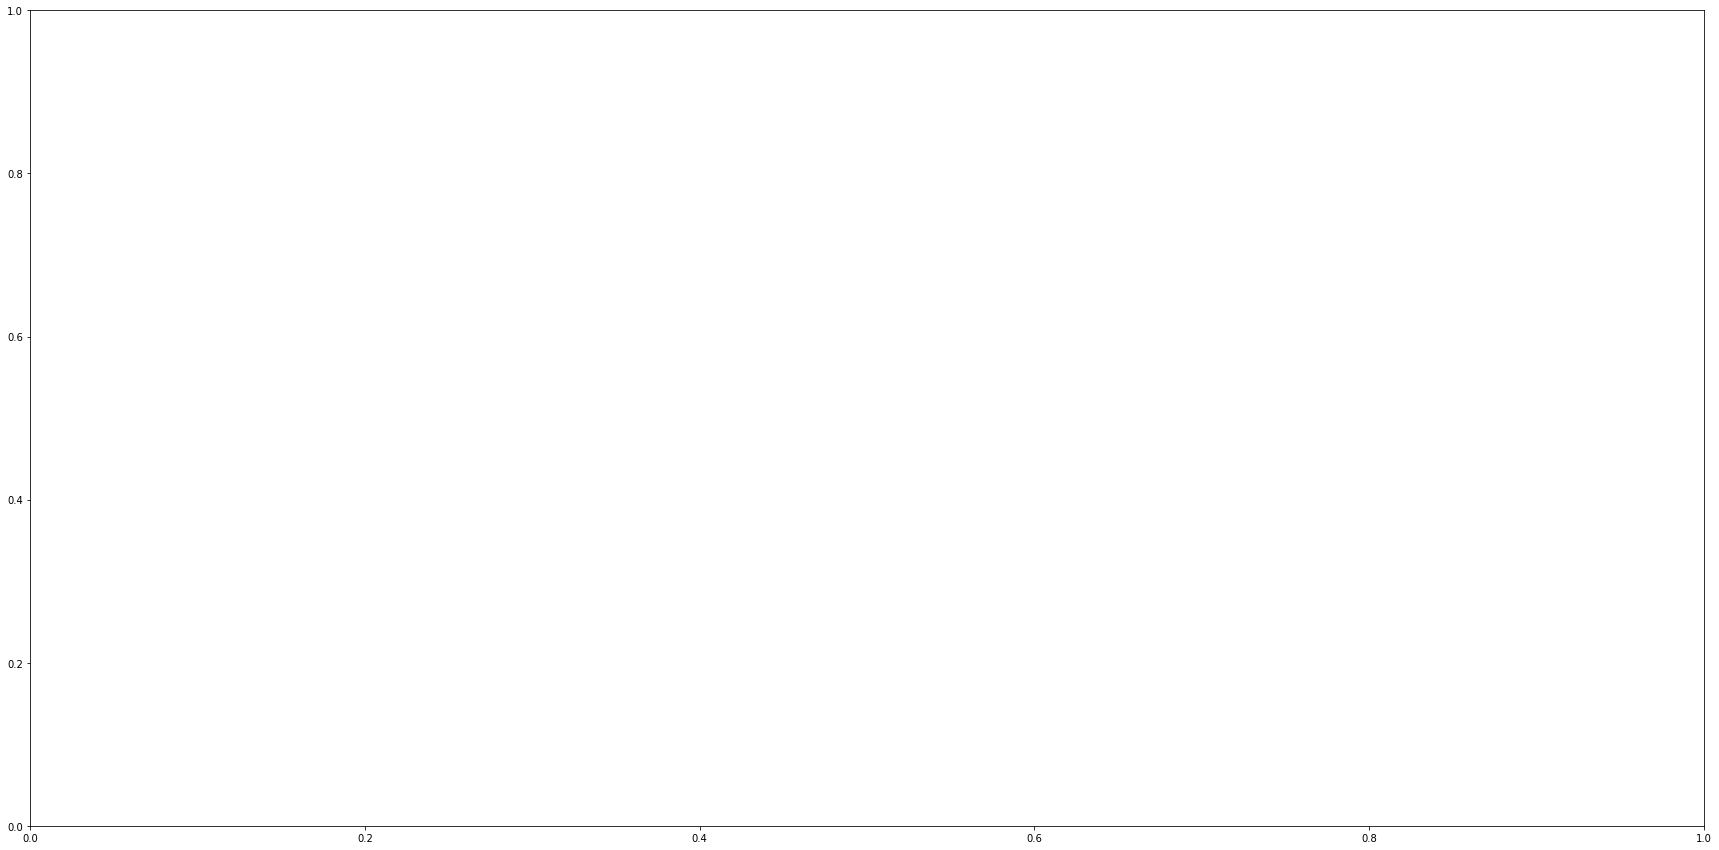

In [23]:
# 날짜 데이터를 기준으로 분석하기 위해, 날짜 데이터를 별도로 추출한다.
# tolist는 리스트화 함수
months = train['fecha_dato'].unique().tolist()

# 제품의 변수 24개를 추출
label_cols = train.columns[24:].tolist()

label_over_time = []
for i in range(len(label_cols)):
  # 매월 각 제품의 총합을 groupby().agg('sum')으로 게산하여 label_sum에 저장한다.
  label_sum = train.groupby(['fecha_dato'])[label_cols[i]].agg('sum')
  label_over_time.append(label_sum.tolist())

label_sum_over_time = []
for i in range(len(label_cols)):
  # 누적 막대그래프를 시각화 하기 위해 n번째 제품의 총합을 정함
  label_sum_over_time.append(np.asarray(label_over_time[i:]))
  print(label_sum_over_time)

# 시각화를 위한 색깔 지정
color_list = ['#F5B7B1', '#D2B4DE', '#AED6F1', '#A2D9CE', '#ABEBC6', '#F9E79F', '#F5CBA7', '#CCD1D1']

# 그림 크기를 사전에 정의함
f, ax = plt.subplots(figsize = (30, 15))
for i in range(len(label_cols)):
  # 24개 제품에 대해 histogram을 그림
  # x축에는 월 데이터, y축에는 누적 총함, 색깔은 8개를 번갈아 가면서 사용하며, 그림의 alpha 값은 0.7로지정함
  sns.barplot(x = months, y = label_sum_over_time[i], color = color_list[i % 8], alpha = 0.7)

# 우측 상단에 legend를 추가함. 
plt.legend([plt.Rectangle((0.0), 1, 1, fc = color_list[i % 8], edgecolor = 'none') 
            for i in range(len(label_cols))], label_cols, loc = 1, ncol = 2, prop = {'size' : 16})

Index(['fecha_dato', 'ncodpers', 'ind_empleado', 'pais_residencia', 'sexo',
       'age', 'fecha_alta', 'ind_nuevo', 'antiguedad', 'indrel',
       'ult_fec_cli_1t', 'indrel_1mes', 'tiprel_1mes', 'indresi', 'indext',
       'conyuemp', 'canal_entrada', 'indfall', 'tipodom', 'cod_prov',
       'nomprov', 'ind_actividad_cliente', 'renta', 'segmento',
       'ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
       'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
       'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
       'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
       'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
       'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
       'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
       'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1'],
      dtype='object')